In [110]:
library(tidyverse)
library(caret)
library(lattice)
library(dygraphs)
library(cowplot)
library(ggthemr)

ggthemr::ggthemr("fresh")
options(repr.plot.width=12, repr.plot.height=5)

Warning message:
“New theme missing the following elements: panel.grid, plot.tag, plot.tag.position”

_Note: All EDA done on training split only_

## What value do the zones add?

### For regression

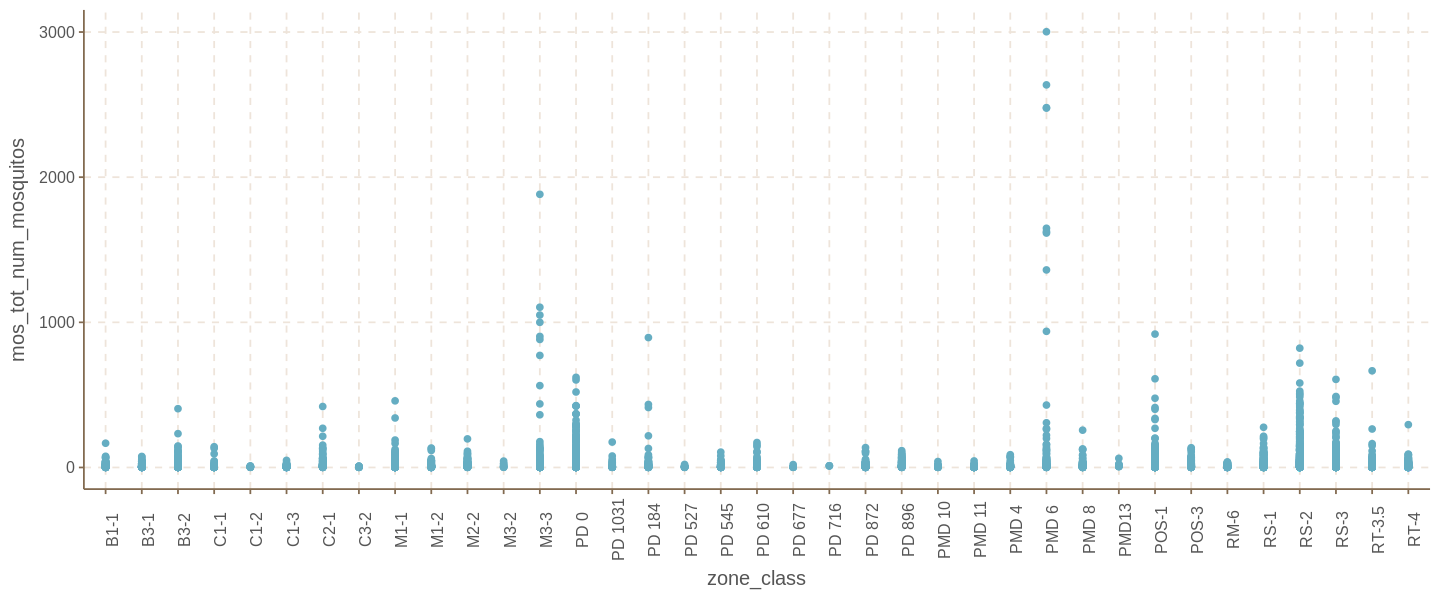

In [111]:
df_train %>% ggplot(aes(y=mos_tot_num_mosquitos,x=zone_class)) + geom_point() + 
    theme(axis.text.x = element_text(angle=90))

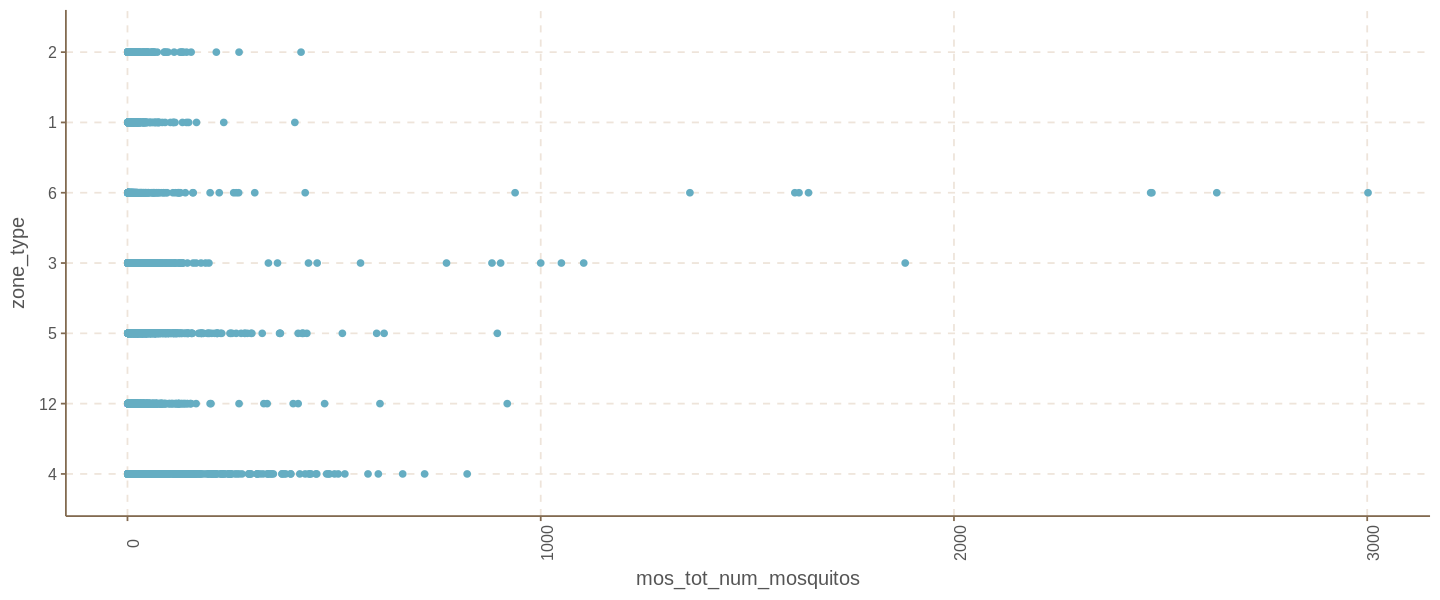

In [112]:
df_train %>% ggplot(aes(y=mos_tot_num_mosquitos,x=zone_type)) + geom_point() + 
    theme(axis.text.x = element_text(angle=90))+coord_flip()

## For classification

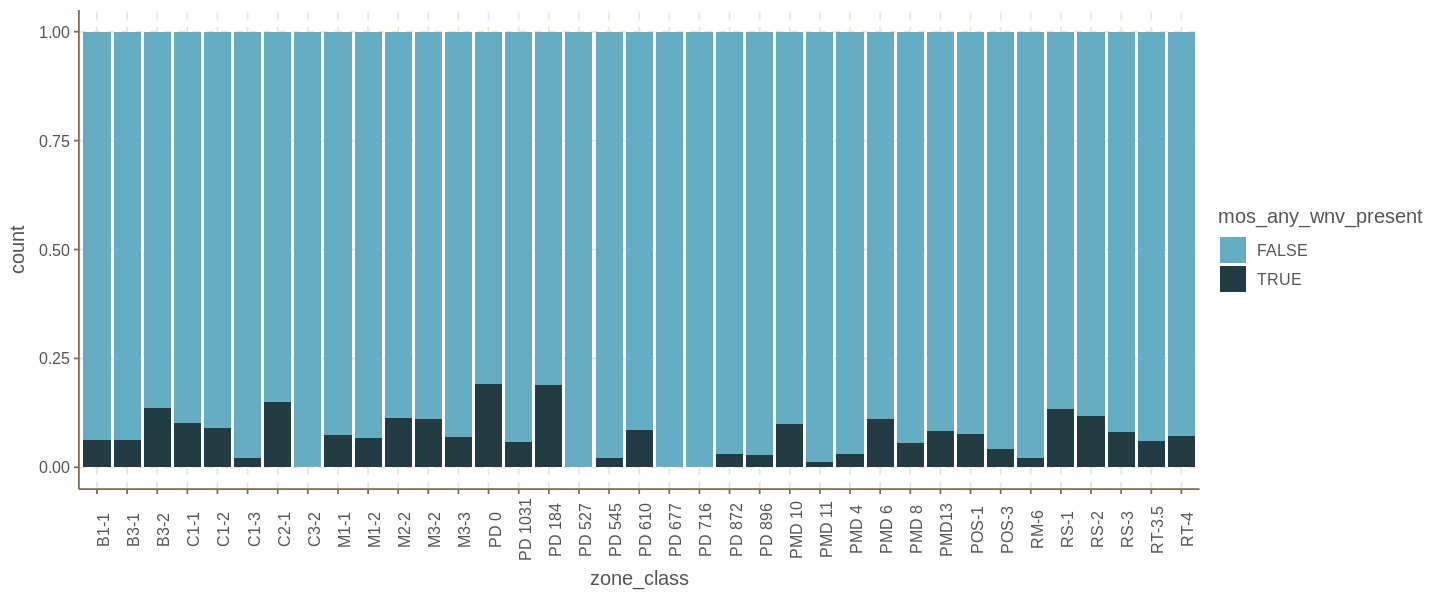

In [113]:
df_train %>% ggplot(aes(fill=mos_any_wnv_present,zone_class)) +
    geom_bar(position="fill")+theme(axis.text.x = element_text(angle=90))

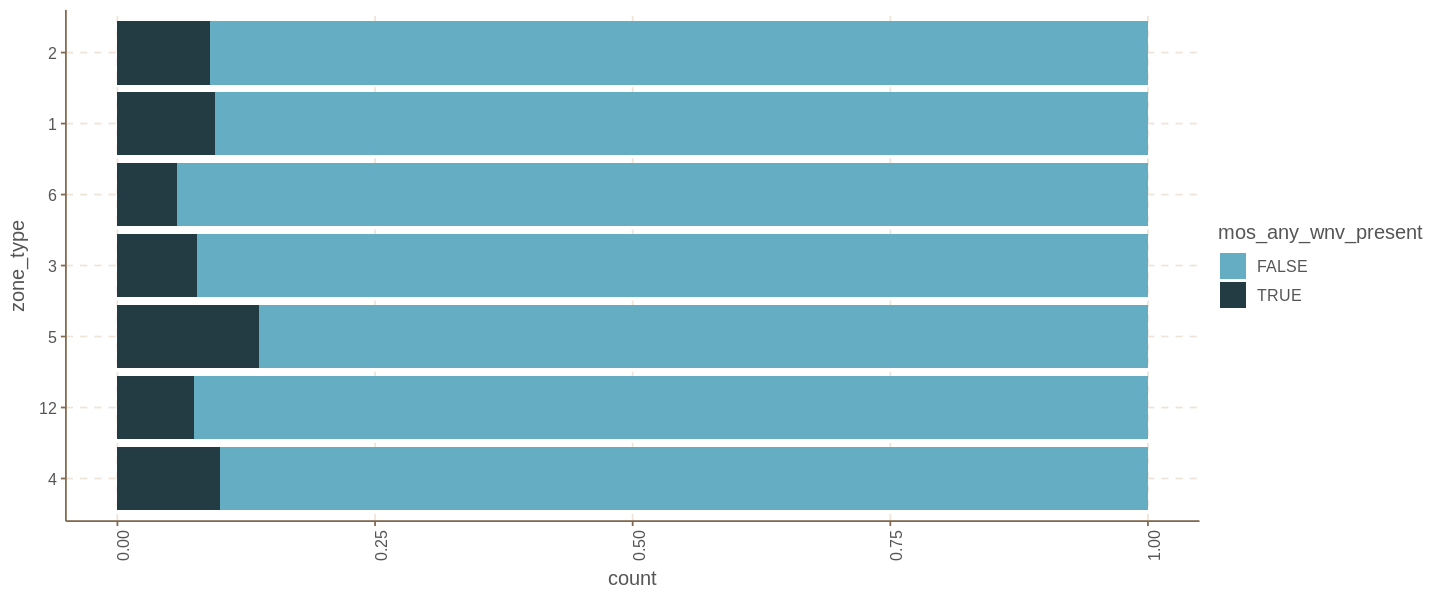

In [114]:
df_train %>% ggplot(aes(fill=mos_any_wnv_present,zone_type)) +
    geom_bar(position="fill")+theme(axis.text.x = element_text(angle=90))+coord_flip()

### Where are the different zones located?

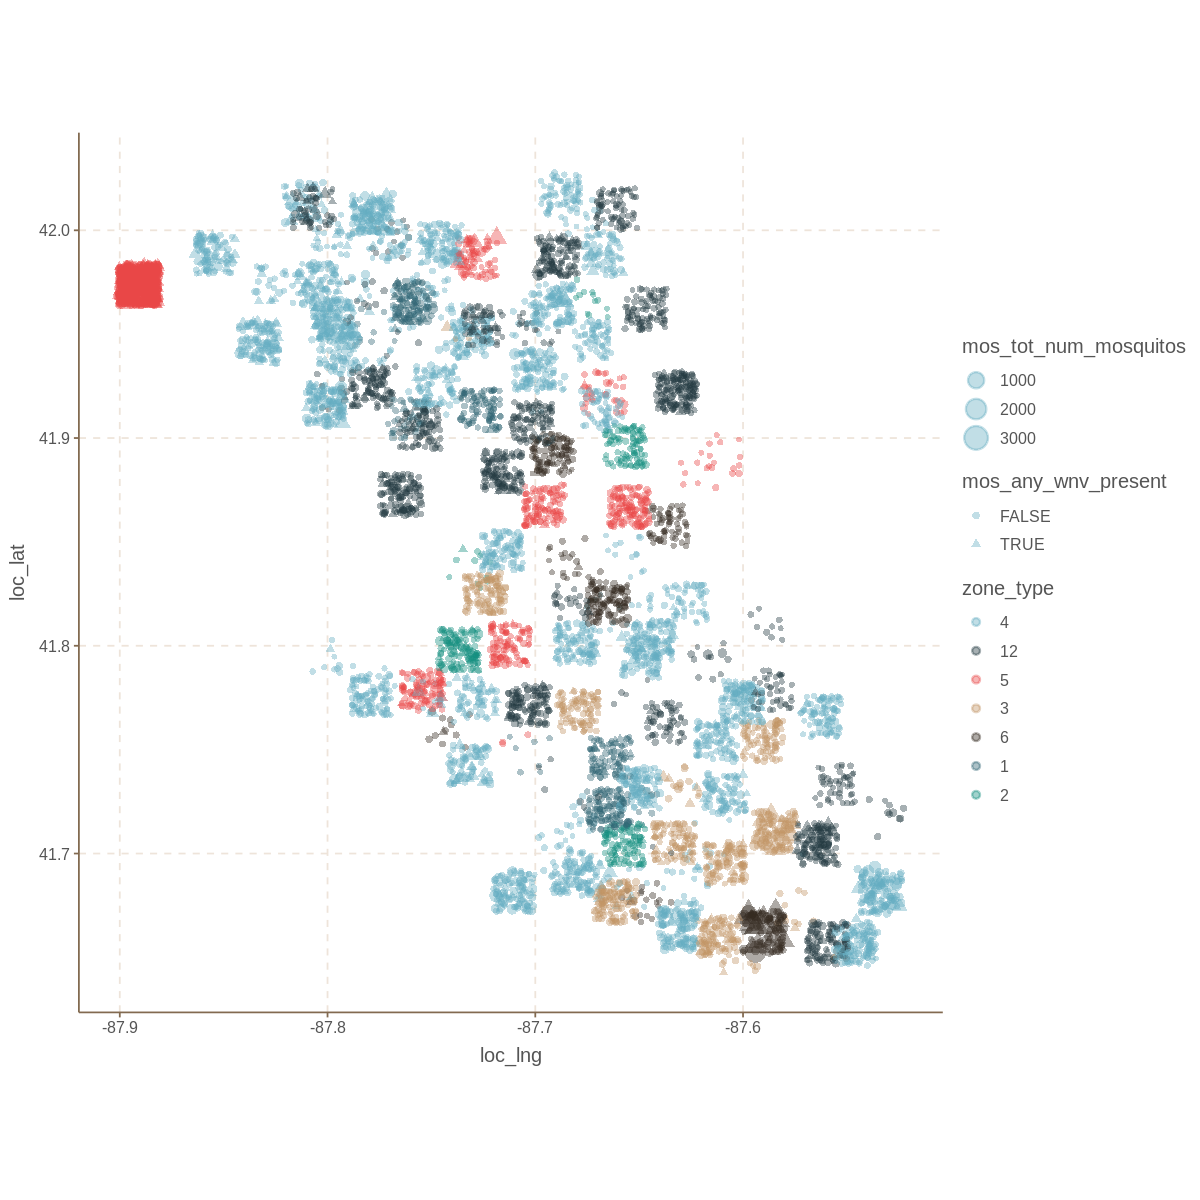

In [118]:
options(repr.plot.width=10, repr.plot.height=10)
df_train %>%
    ggplot(aes(loc_lng,loc_lat,color=zone_type,shape=mos_any_wnv_present,size=mos_tot_num_mosquitos))+
    geom_jitter(width = 0.01, height = 0.01, alpha = 0.4, stroke = 1)+
    coord_equal()
options(repr.plot.width=12, repr.plot.height=5)

What's going on with that dark red square on the top left?

And note the large sized black triangles at the bottom right too. Interesting.

# Do the trap variables offer anything?

In [85]:
df_train %>% select(starts_with("trap")) %>% head()

trap_trap_name trap_satellite_ind trap_trap_type
1 T002           FALSE              GRAVID        
2 T007           FALSE              CDC           
3 T015           FALSE              GRAVID        
4 T045           FALSE              GRAVID        
5 T046           FALSE              CDC           
6 T048           FALSE              GRAVID

## For regression?

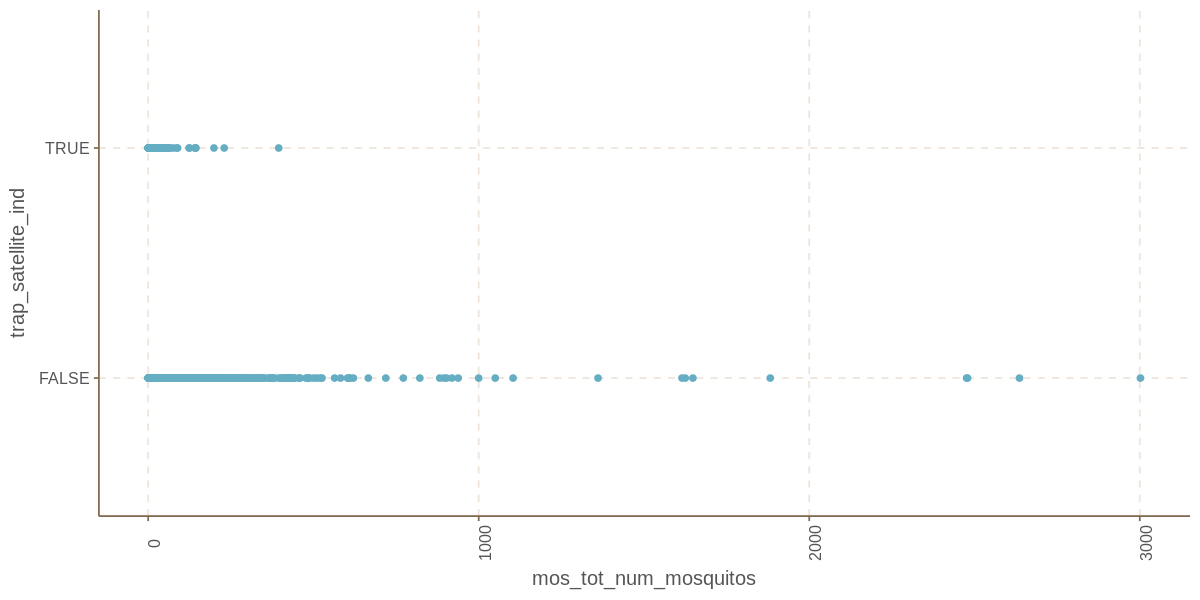

In [86]:
options(repr.plot.width=10, repr.plot.height=5)
df_train %>% ggplot(aes(y=mos_tot_num_mosquitos,x=trap_satellite_ind)) + geom_point() + 
    theme(axis.text.x = element_text(angle=90)) + coord_flip()

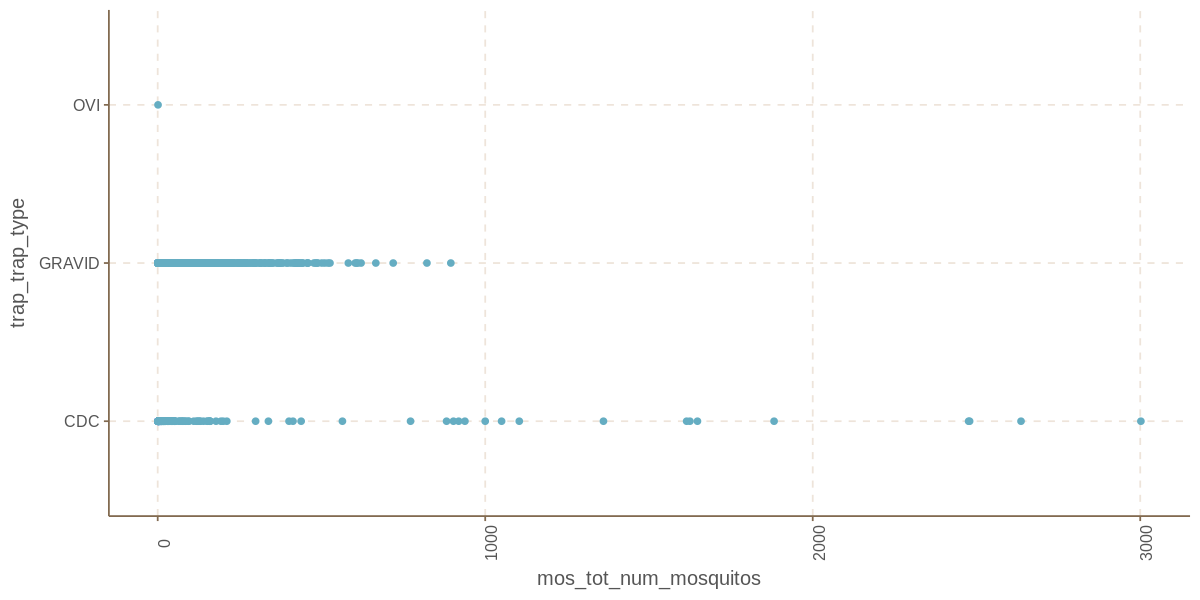

In [87]:
df_train %>% ggplot(aes(y=mos_tot_num_mosquitos,x=trap_trap_type)) + geom_point() + 
    theme(axis.text.x = element_text(angle=90)) + coord_flip()

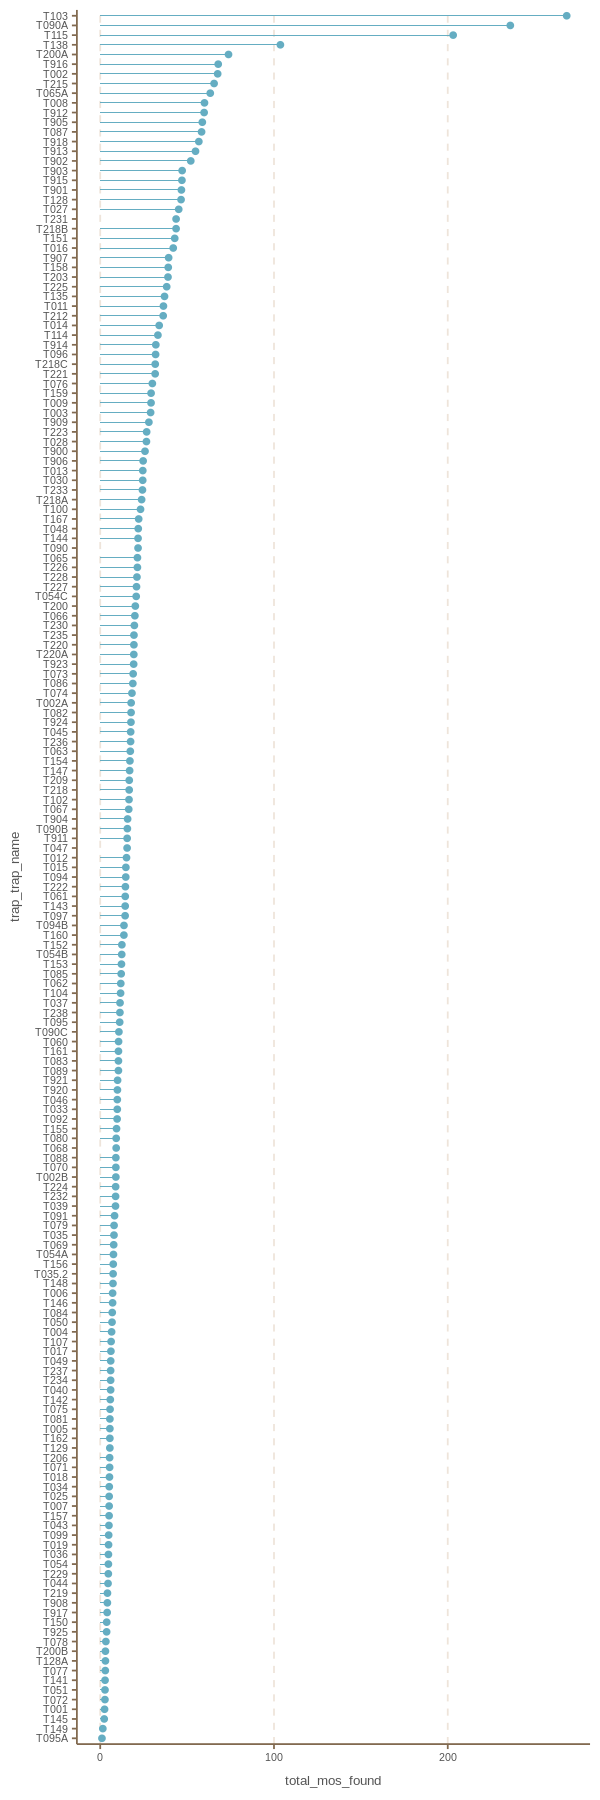

In [88]:
options(repr.plot.width=5, repr.plot.height=15)
df_train %>% 
    select(mos_tot_num_mosquitos, trap_trap_name) %>%
    group_by(trap_trap_name) %>%
    summarize(total_mos_found = sum(mos_tot_num_mosquitos)/length(trap_trap_name)) %>%
    mutate(trap_trap_name = factor(trap_trap_name,levels = trap_trap_name[order(.$total_mos_found)])) %>%
    ggplot(aes(y=total_mos_found,x=trap_trap_name)) +
    geom_point()+geom_col(width = .1)+theme(text = element_text(size=8))+
    coord_flip() + theme(panel.grid.major.y = element_blank())

## For classification?

Why is that one trap "T090A" 100% infected?

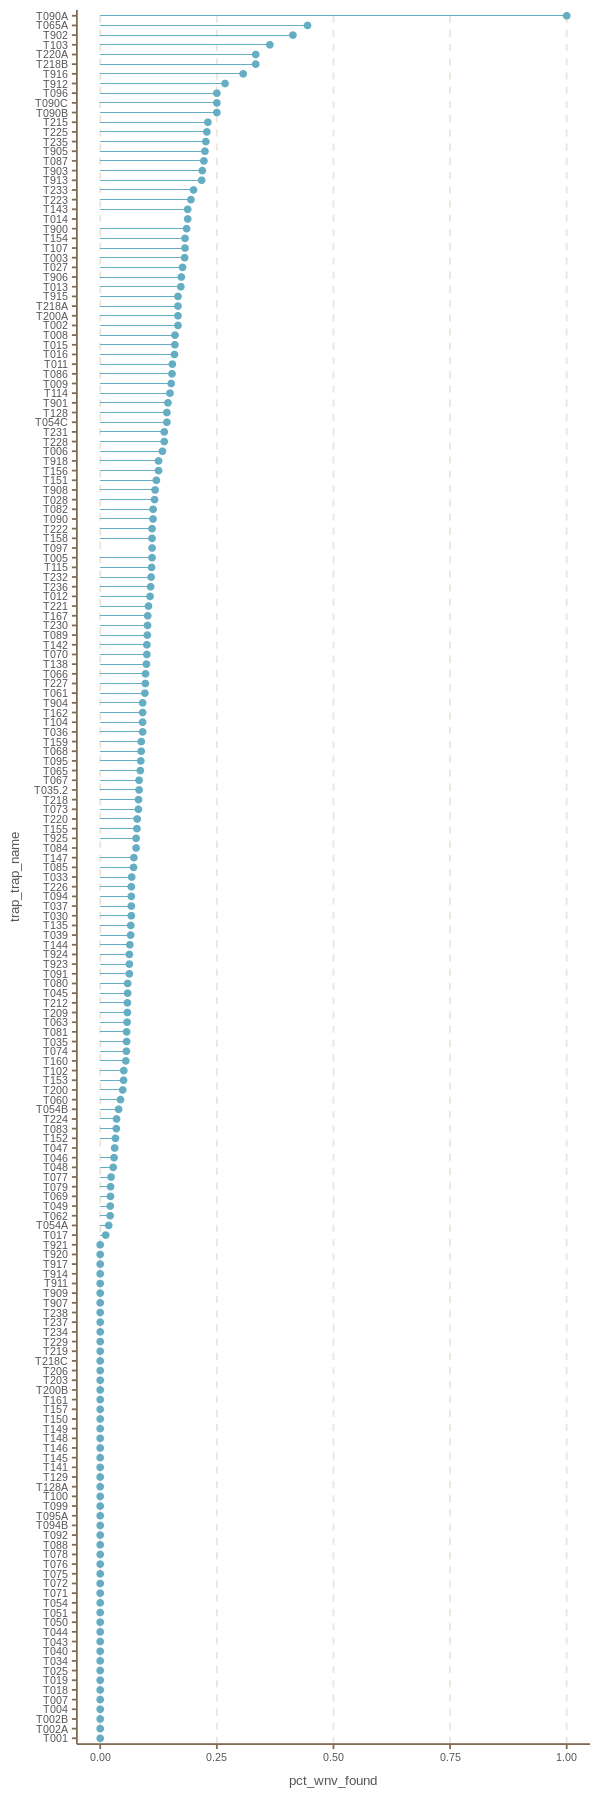

In [89]:
options(repr.plot.width=5, repr.plot.height=15)
df_train %>% 
    select(mos_any_wnv_present, trap_trap_name) %>%
    group_by(trap_trap_name) %>%
    summarize(pct_wnv_found = sum(mos_any_wnv_present)/length(trap_trap_name)) %>%
    mutate(trap_trap_name = factor(trap_trap_name,levels = trap_trap_name[order(.$pct_wnv_found)])) %>%
    ggplot(aes(y=pct_wnv_found,x=trap_trap_name)) +
    geom_point()+geom_col(width = .1)+theme(text = element_text(size=8))+
    coord_flip() + theme(panel.grid.major.y = element_blank())

The satellite variable adds no information

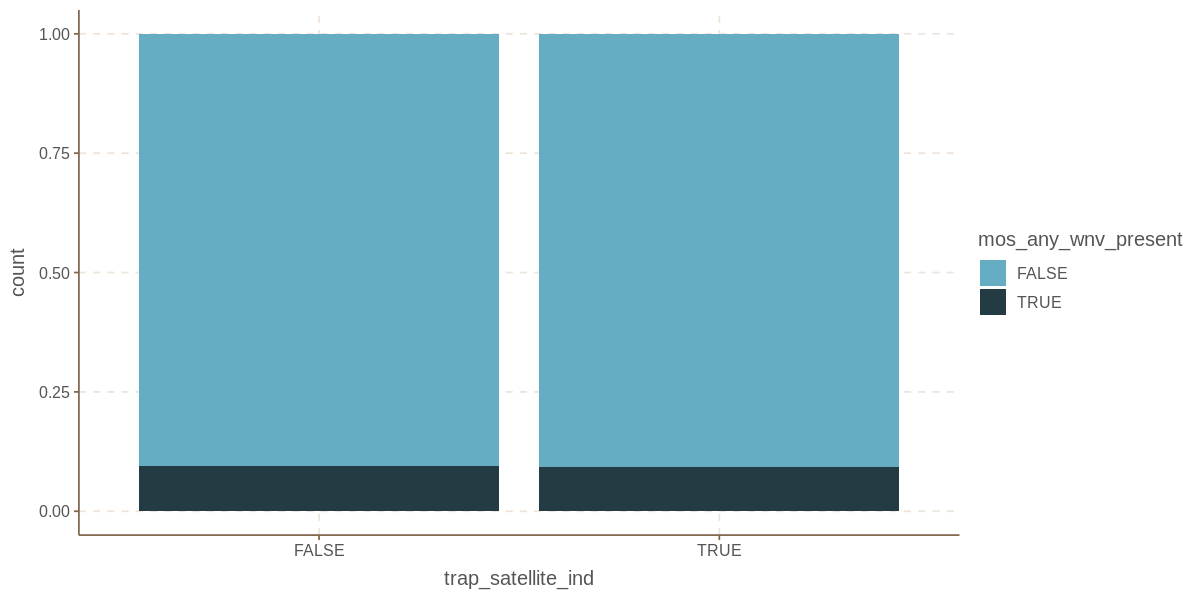

In [90]:
options(repr.plot.width=10, repr.plot.height=5)
df_train %>%
    ggplot(aes(fill=mos_any_wnv_present,trap_satellite_ind))+
    geom_bar(position = "fill")

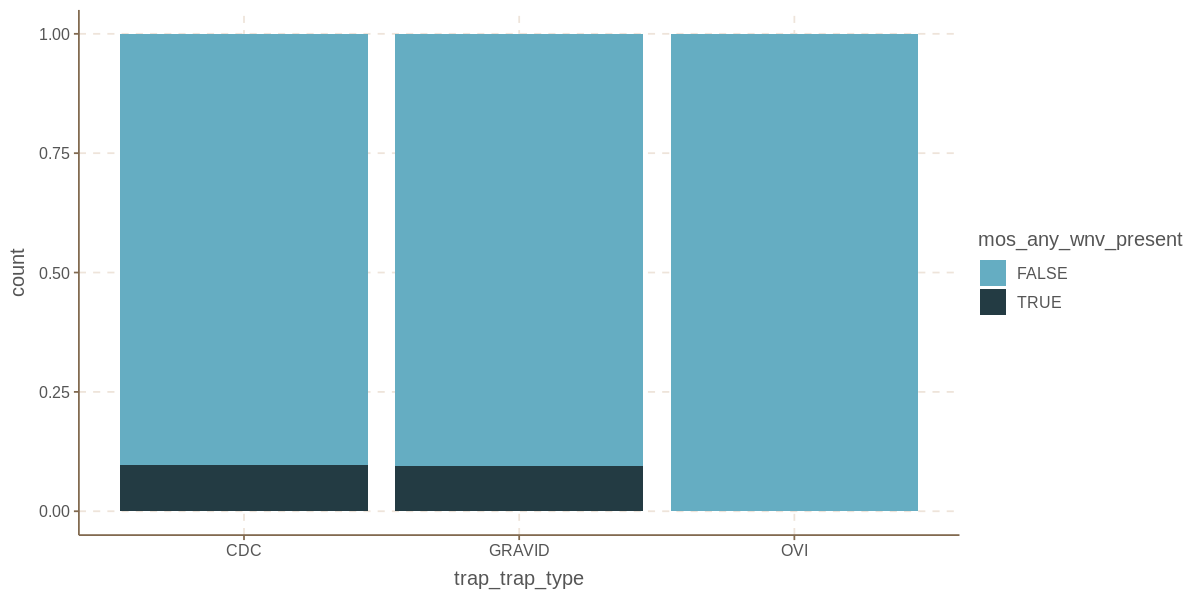

In [91]:
df_train %>%
    ggplot(aes(fill=mos_any_wnv_present,trap_trap_type))+
    geom_bar(position = "fill")

# What do the location variables offer?

In [92]:
df_loc = df_train %>% dplyr::select(starts_with("loc_"),
                                    "mos_any_wnv_present","mos_tot_num_mosquitos")

In [93]:
head(df_loc)

loc_lat  loc_lng   loc_lat_lng_src loc_zipcode loc_census_block_group_id
1 41.95630 -87.79752 CDPH            60634       170311701001             
2 41.99549 -87.76961 CDPH            60646       170311201003             
3 41.97418 -87.82524 CDPH            60656       170311005005             
4 41.92170 -87.66696 CDPH            60614       170318325001             
5 41.89222 -87.69170 CDPH            60612       170318367002             
6 41.86692 -87.65492 CDPH            60608       170312838001             
  loc_census_tract_id loc_community  mos_any_wnv_present mos_tot_num_mosquitos
1 17031170100         DUNNING        FALSE               2                    
2 17031120100         FOREST GLEN    FALSE               1                    
3 17031100500         NORWOOD PARK   FALSE               5                    
4 17031832500         LINCOLN PARK   FALSE               2                    
5 17031836700         HUMBOLDT PARK  FALSE               1                    
6 17031283800         NEAR WEST SIDE FALSE               3

## Lat Long Source

Lat Long source seems to have some predictive power

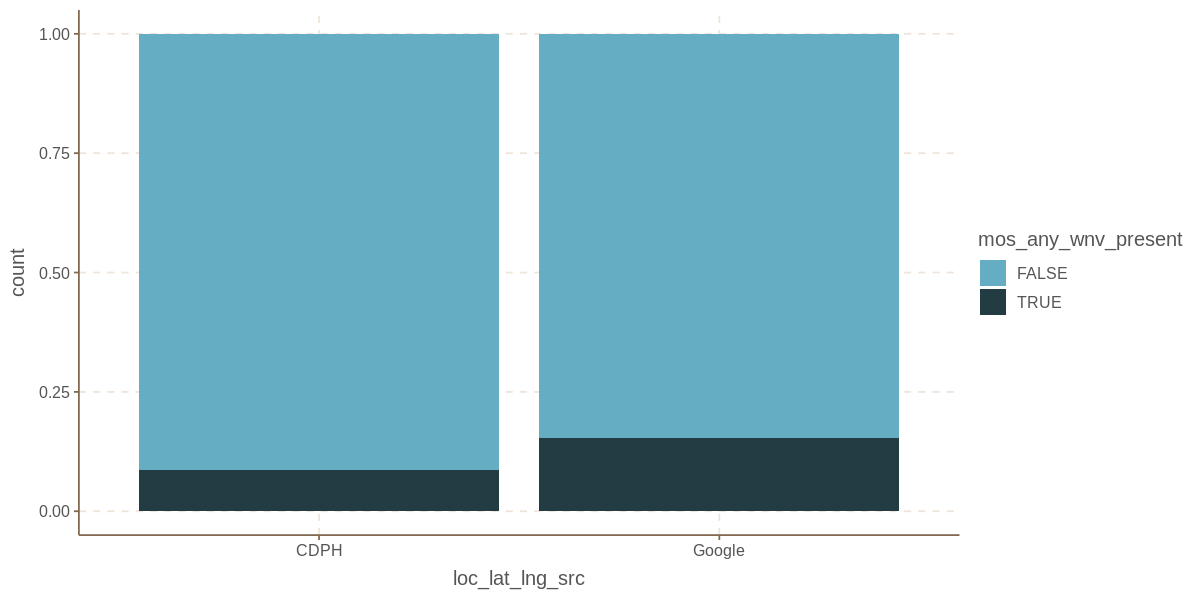

In [94]:
df_loc %>%
    ggplot(aes(fill=mos_any_wnv_present,loc_lat_lng_src))+
    geom_bar(position = "fill")

## Community

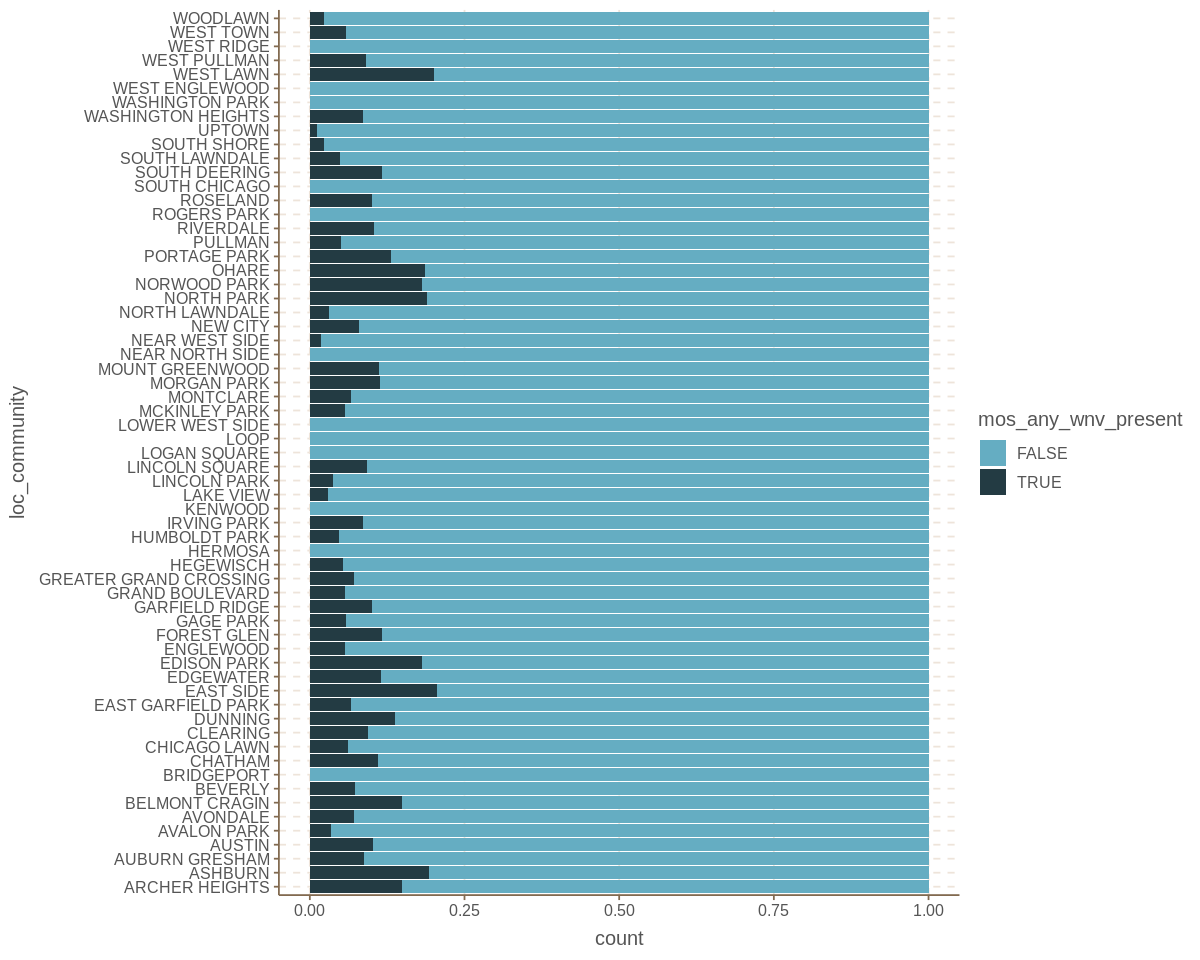

In [95]:
options(repr.plot.width=10, repr.plot.height=8)
df_loc %>%
    ggplot(aes(fill=mos_any_wnv_present,loc_community))+
    geom_bar(position = "fill") + coord_flip()

Same plot as before, but color coded by Community

In [96]:
options(repr.plot.width=10, repr.plot.height=10)
color_pal = sample(colors(distinct = T),70,replace = F)
cust_theme = define_palette(swatch = color_pal, gradient = c(head(color_pal,1),tail(color_pal,1)))

Warning message:
“New theme missing the following elements: panel.grid, plot.tag, plot.tag.position”

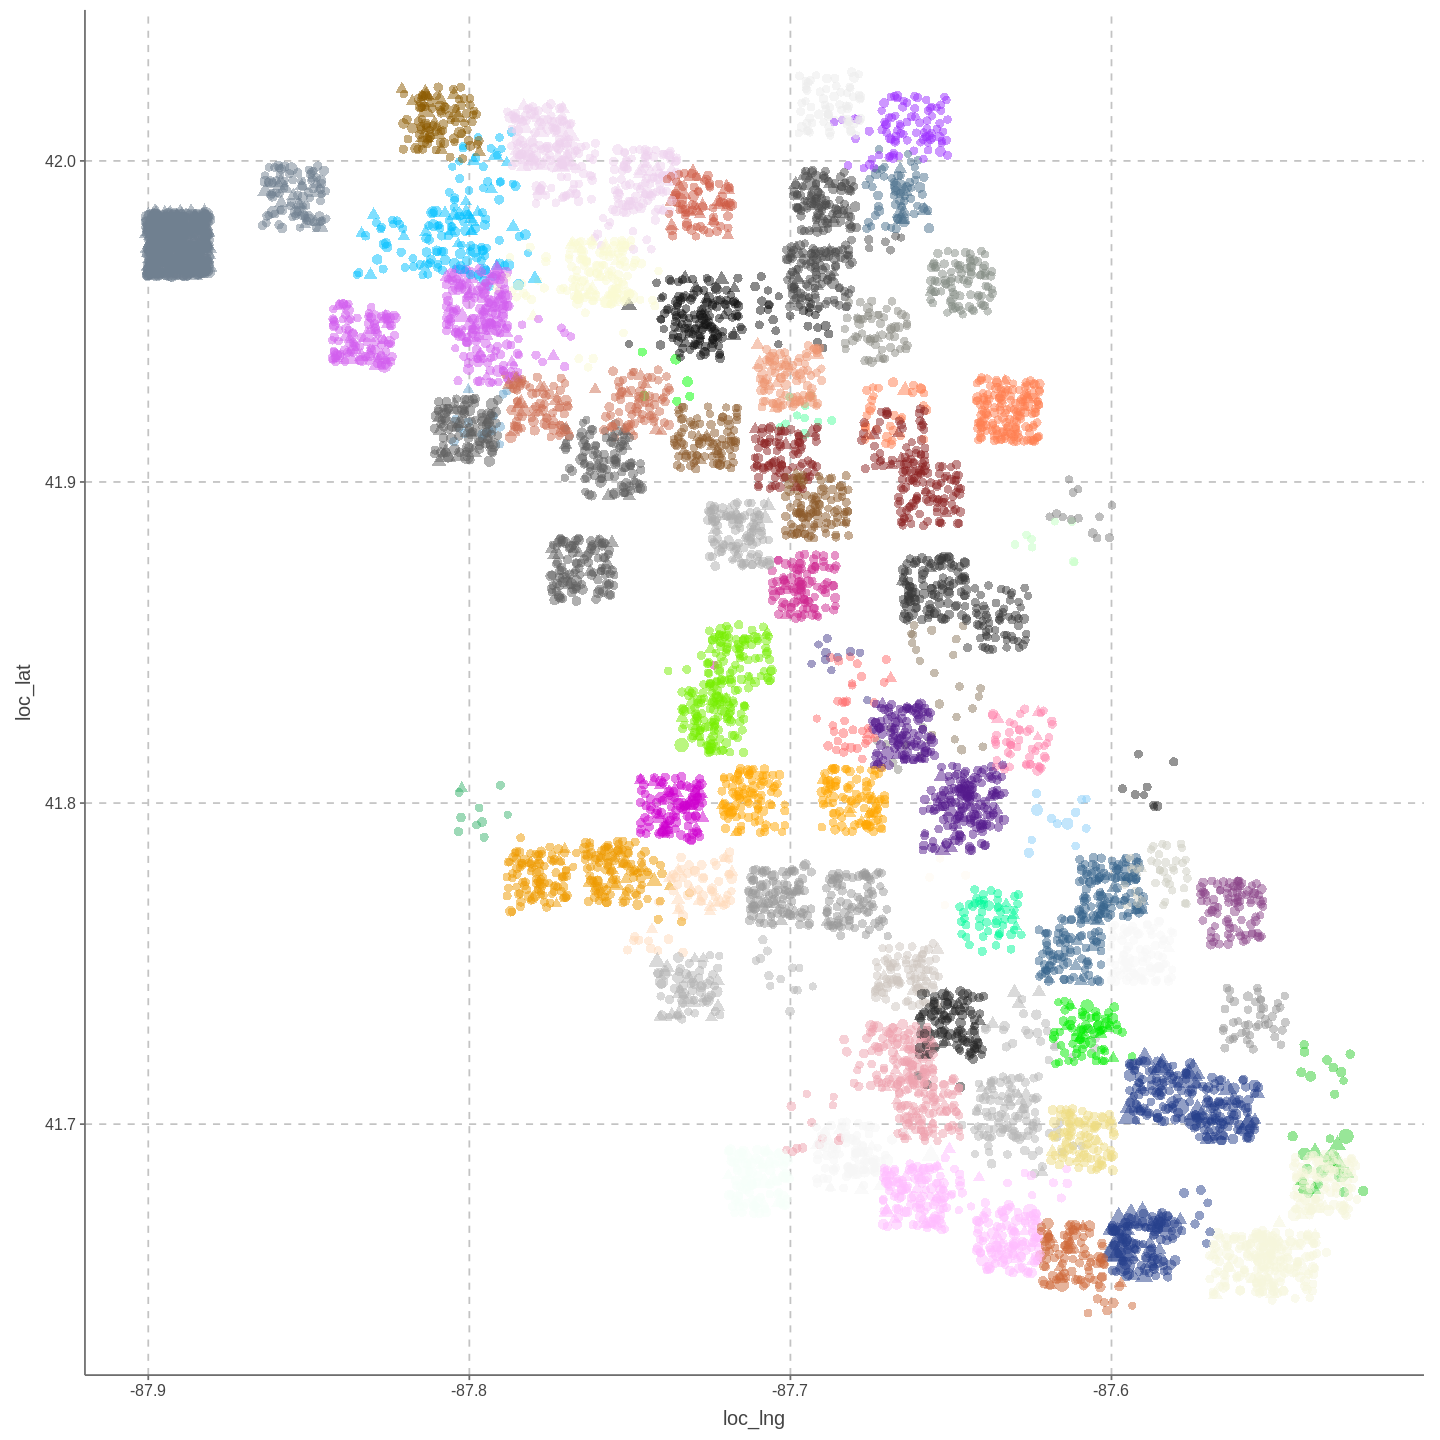

In [108]:
ggthemr(cust_theme)
options(repr.plot.width=12, repr.plot.height=12)
df_train %>%
    ggplot(aes(loc_lng,loc_lat,color=loc_community,shape=mos_any_wnv_present,size=mos_tot_num_mosquitos))+
    geom_jitter(width = 0.01, height = 0.01, alpha = 0.5, stroke=2)+
    coord_equal()+
    theme(legend.position = "none")

In [100]:
ggthemr("fresh")

Warning message:
“New theme missing the following elements: panel.grid, plot.tag, plot.tag.position”

## Block

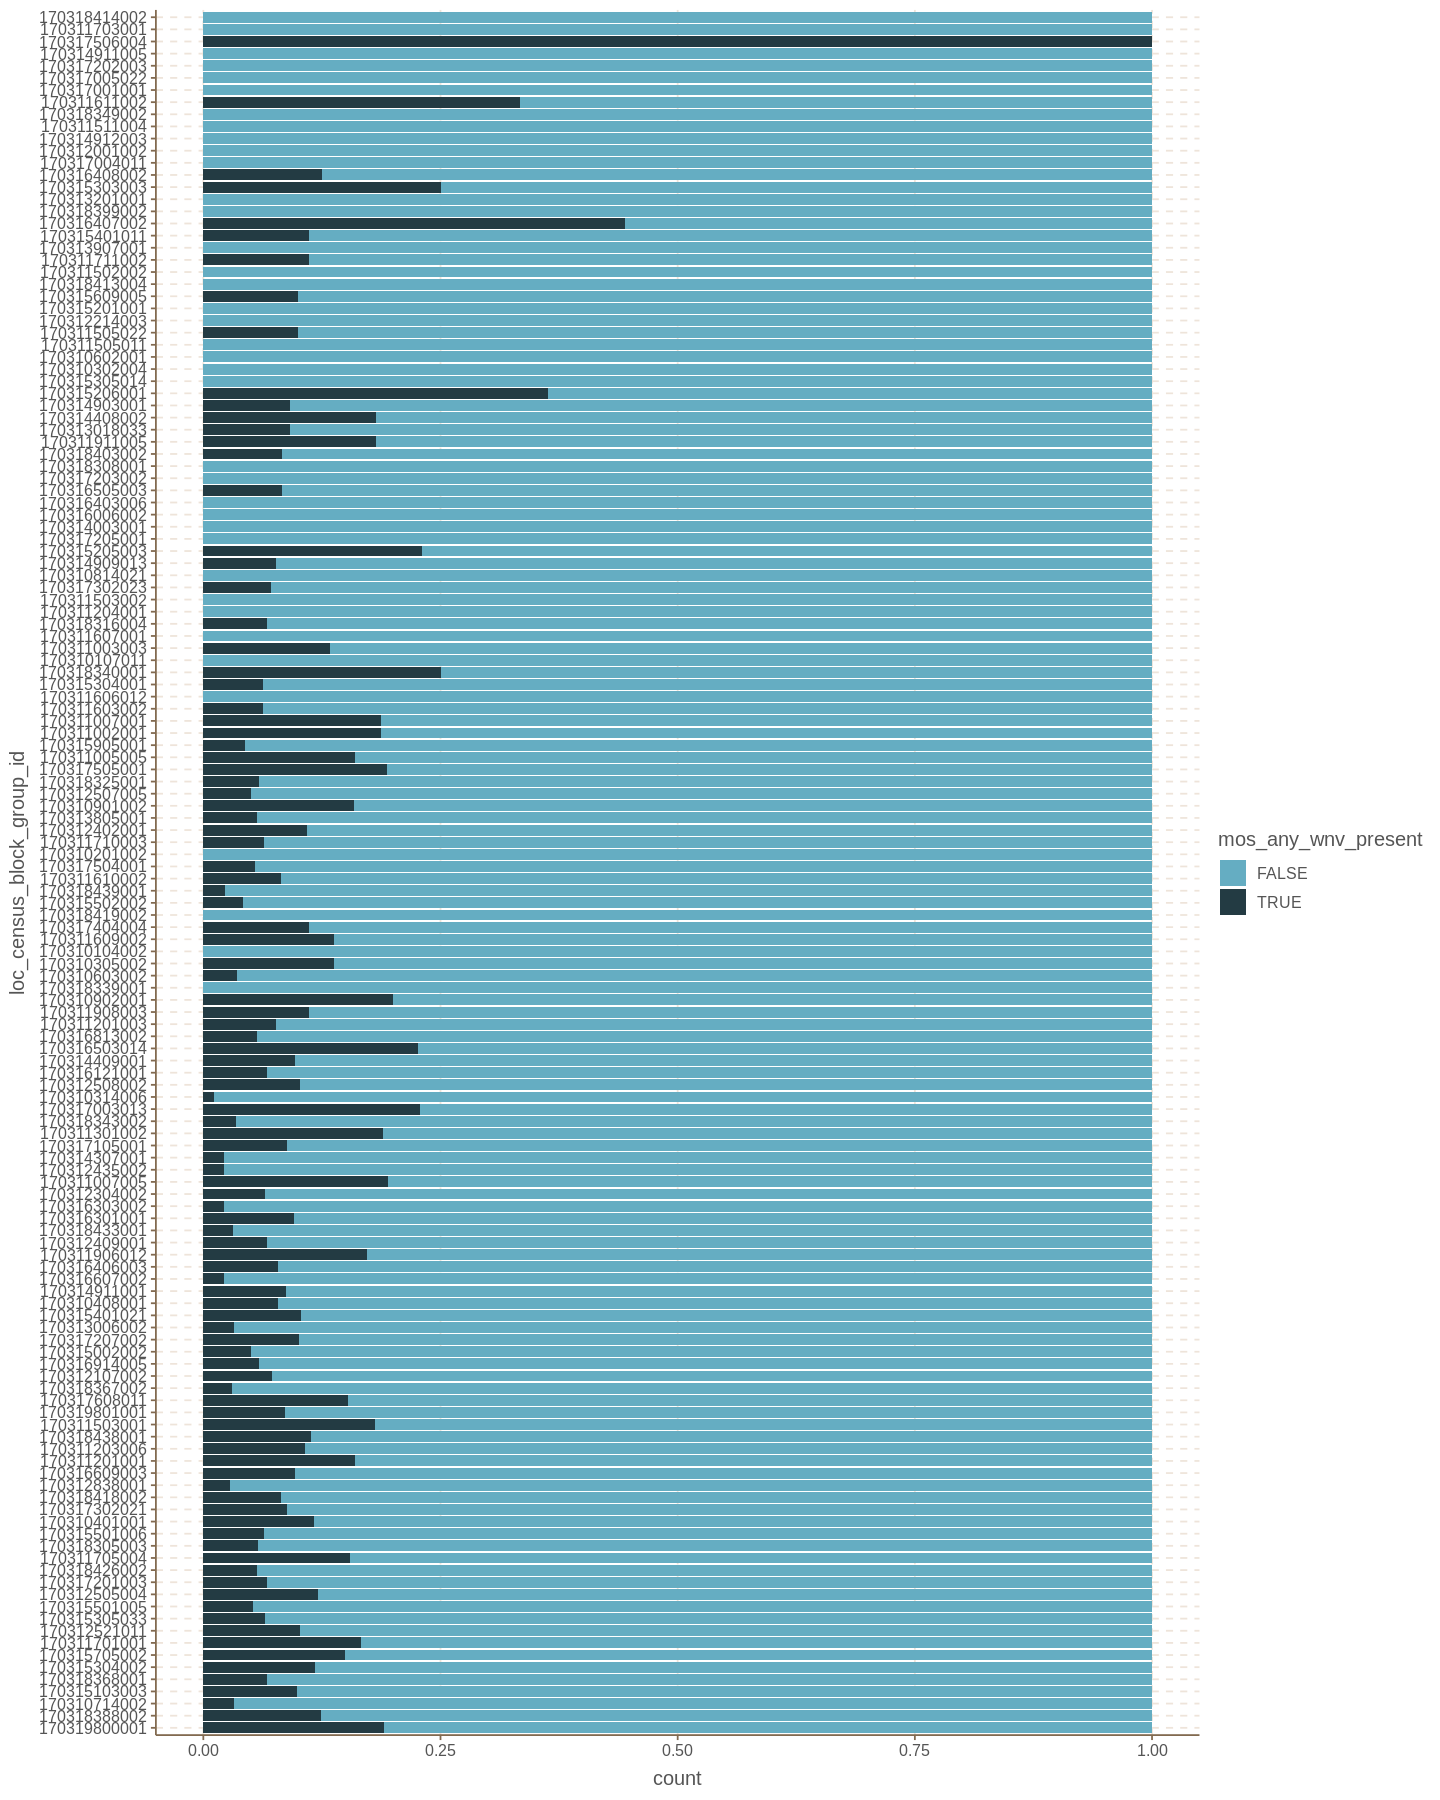

In [102]:
options(repr.plot.width=12, repr.plot.height=15)
df_loc %>%
    ggplot(aes(fill=mos_any_wnv_present,loc_census_block_group_id))+
    geom_bar(position = "fill") + coord_flip()

Zipcode certainly has predictive power. Some zipcodes are not affected at all.

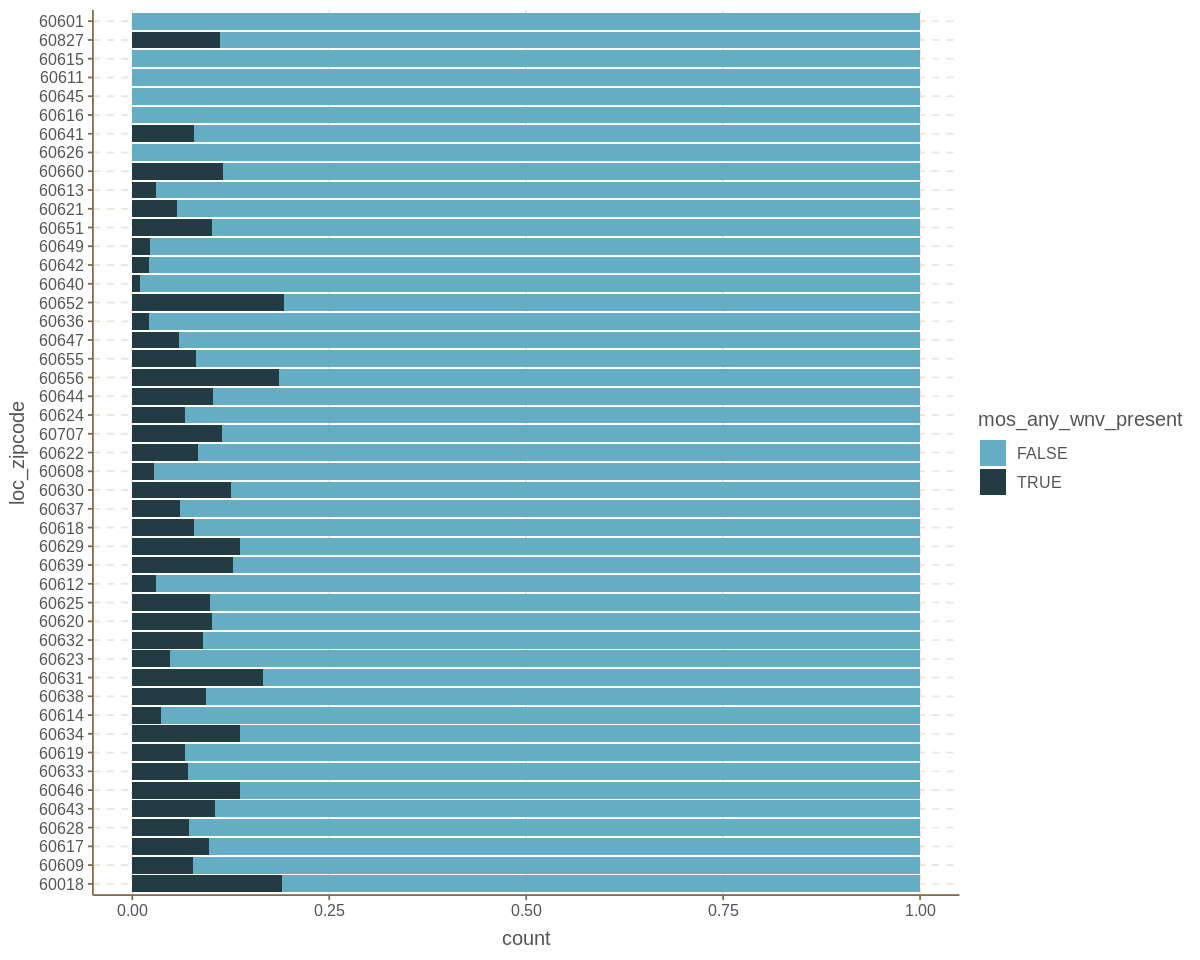

In [103]:
options(repr.plot.width=10, repr.plot.height=8)
df_loc %>%
    ggplot(aes(fill=mos_any_wnv_present,loc_zipcode))+
    geom_bar(position = "fill") + coord_flip()

How do the zipcodes with active WNV vary over time?

Warning message:
“Transformation introduced infinite values in discrete y-axis”Warning message in sqrt(x):
“NaNs produced”Warning message:
“Removed 3927 rows containing missing values (geom_point).”

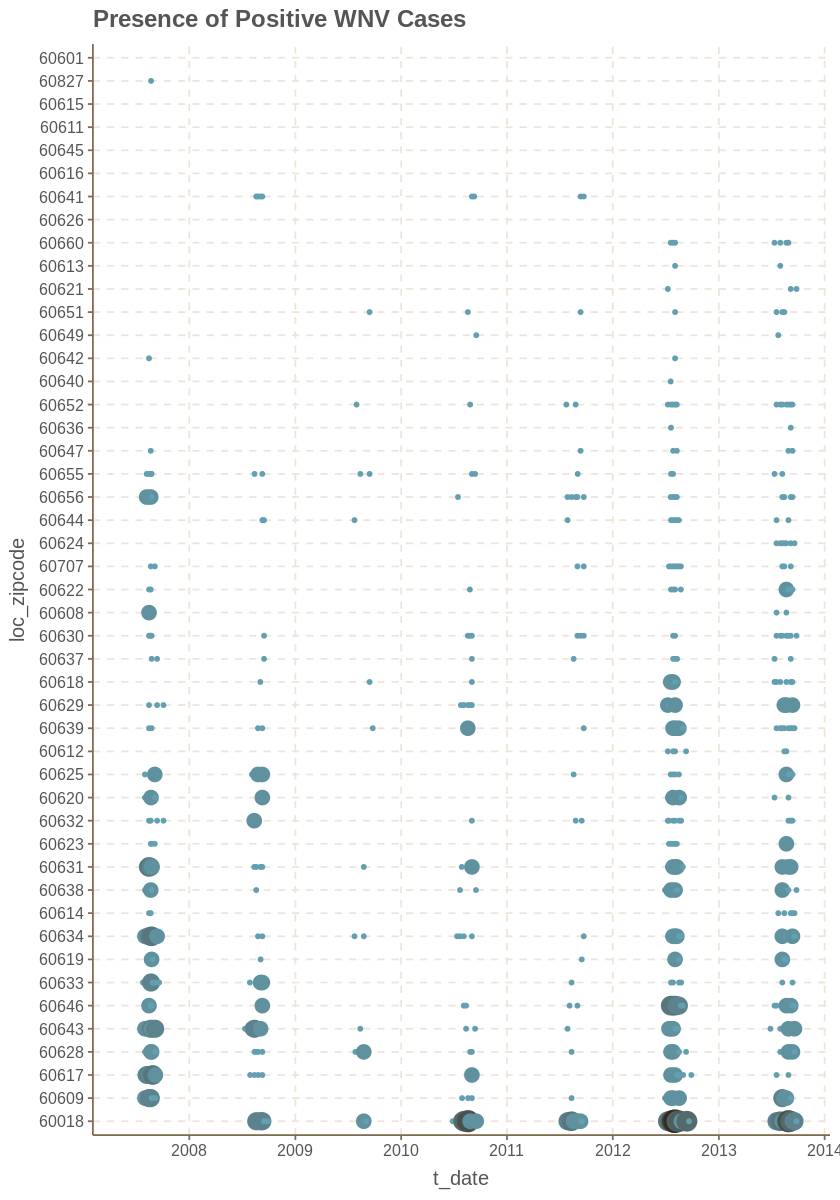

In [139]:
options(repr.plot.width=7, repr.plot.height=10)
df_train %>%
    group_by(t_date,loc_zipcode) %>%
    tally(mos_any_wnv_present) %>%
    ggplot()+
    geom_point(aes(x=t_date,size=n,y = loc_zipcode, color = n))+
    theme(legend.position = "none")+
    scale_size_continuous(trans = "log")+
    scale_x_date(date_breaks = "1 year", date_labels = "%Y")+
    labs(title = "Presence of Positive WNV Cases")

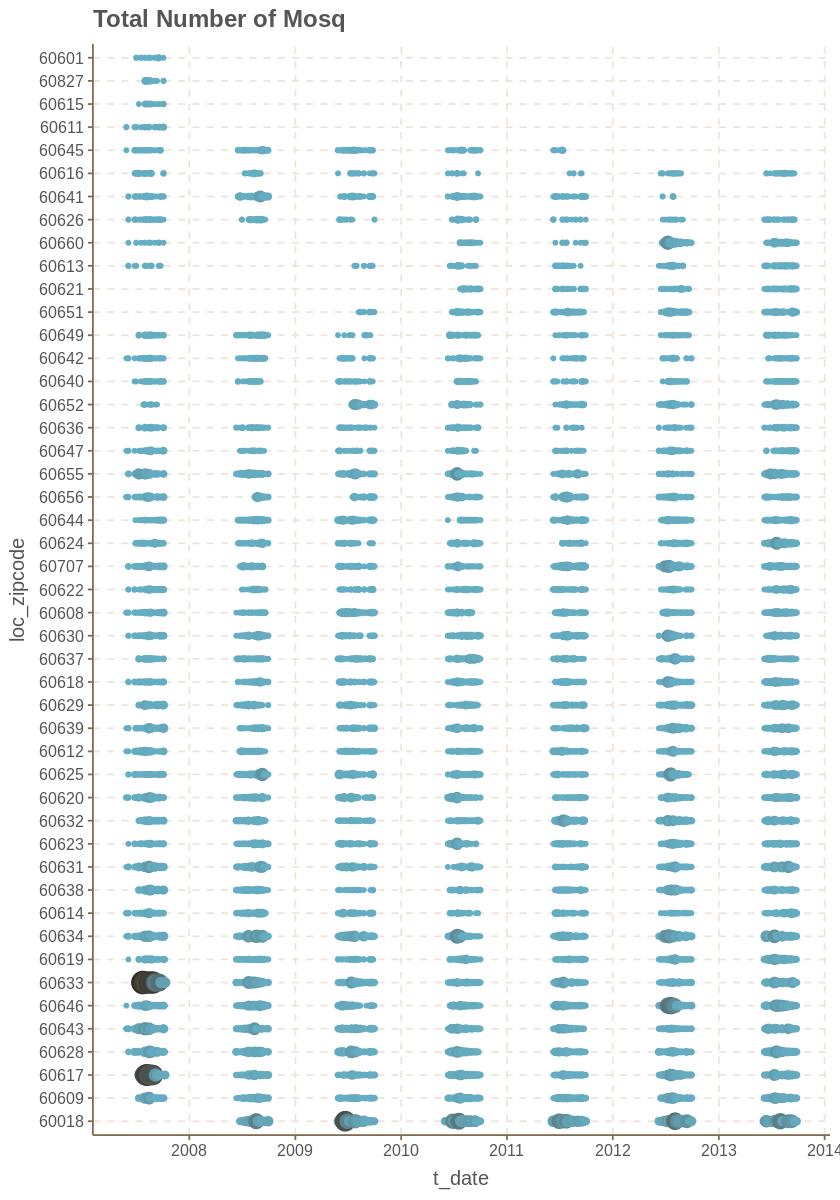

In [143]:
options(repr.plot.width=7, repr.plot.height=10)
df_train %>%
    group_by(t_date,loc_zipcode) %>%
    tally(mos_tot_num_mosquitos) %>%
    ggplot()+
    geom_point(aes(x=t_date,size=n,y = loc_zipcode, color = n))+
    theme(legend.position = "none")+
    scale_x_date(date_breaks = "1 year", date_labels = "%Y")+
    labs(title = "Total Number of Mosq")

Putting both the count of mosq & the # of cases together: A bit complex plot; yet something interesting -- in some cases, the # of mosq is quite high, yet, not as many cases.

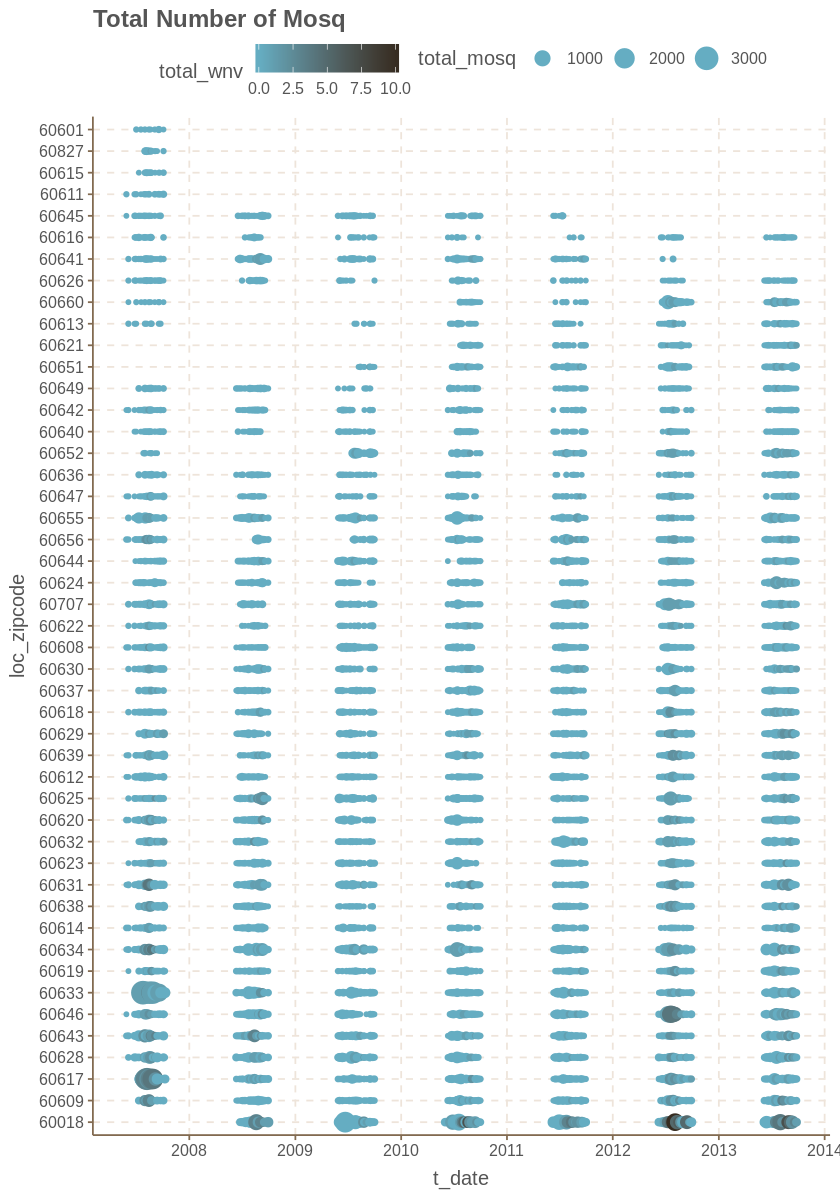

In [148]:
options(repr.plot.width=7, repr.plot.height=10)
df_train %>%
    group_by(t_date,loc_zipcode) %>%
    summarize(total_mosq = sum(mos_tot_num_mosquitos),total_wnv = sum(mos_any_wnv_present)) %>%
    ggplot()+
    geom_point(aes(x=t_date,size=total_mosq,y = loc_zipcode, color = total_wnv))+
    theme(legend.position = "top")+
    scale_x_date(date_breaks = "1 year", date_labels = "%Y")+
    labs(title = "Total Number of Mosq")

# Does SES offer any value?

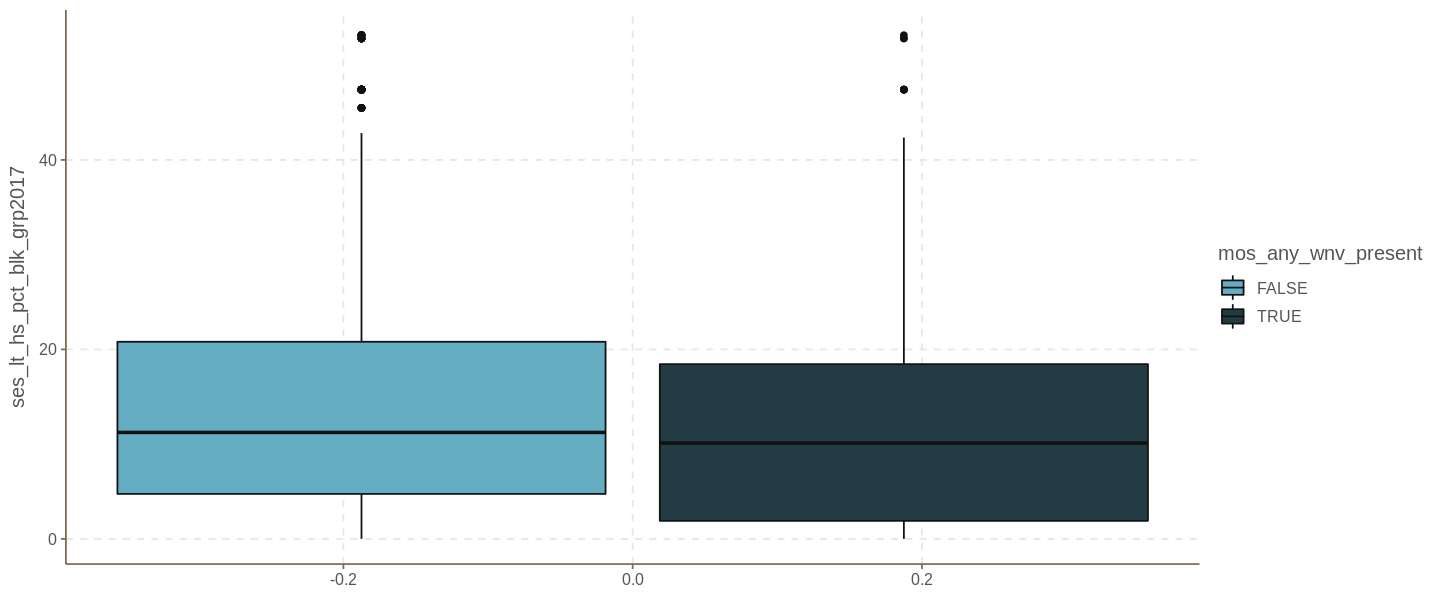

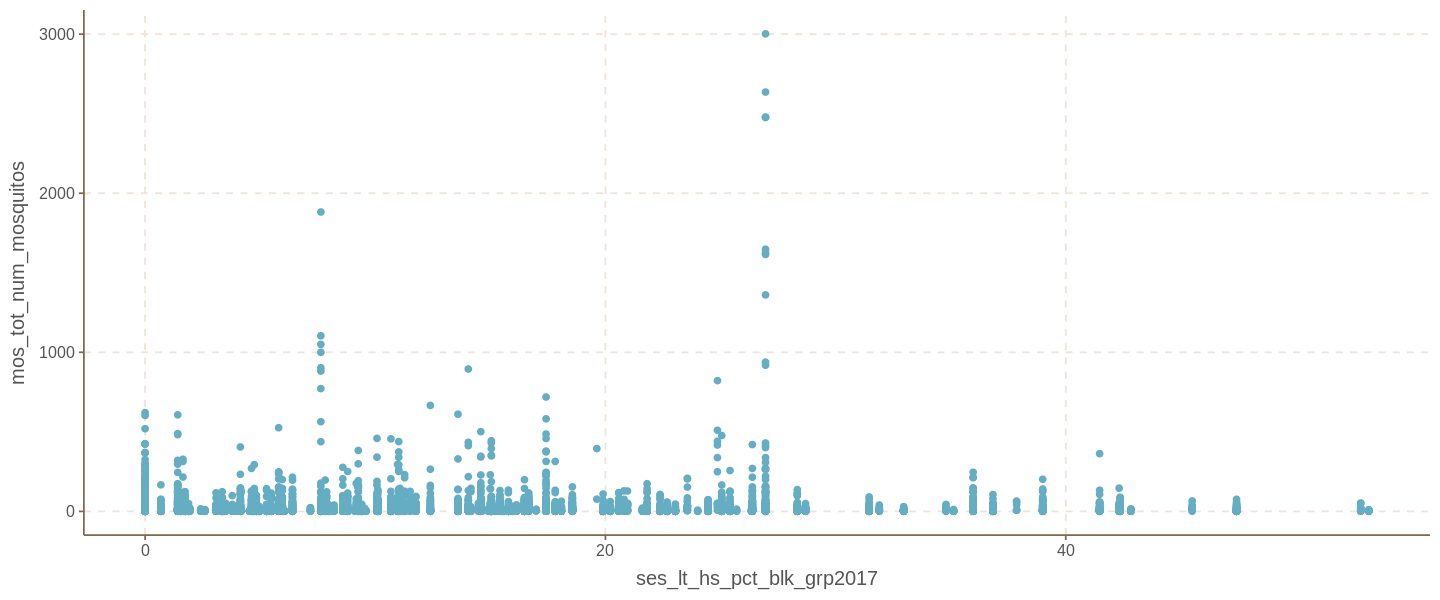

In [169]:
options(repr.plot.width=12, repr.plot.height=5)
df_train %>%
    ggplot()+
    geom_boxplot(aes(y=ses_lt_hs_pct_blk_grp2017,fill=mos_any_wnv_present))
df_train %>%
    ggplot()+
    geom_point(aes(x=ses_lt_hs_pct_blk_grp2017,y=mos_tot_num_mosquitos))

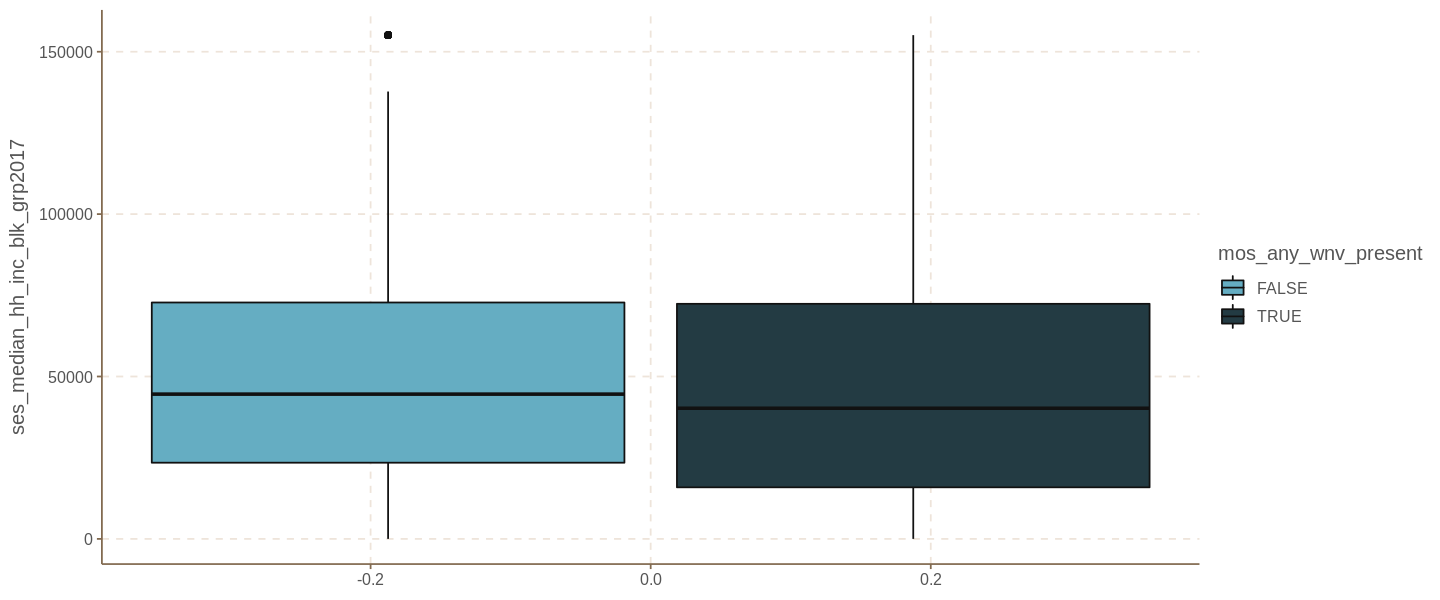

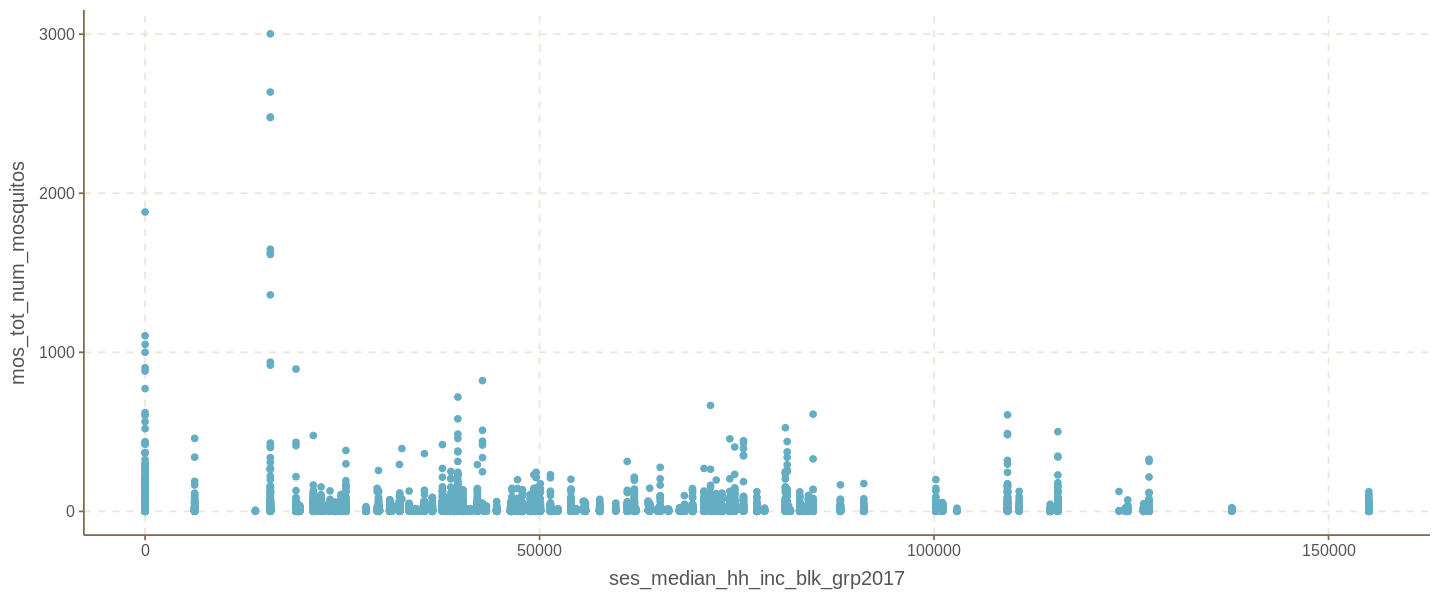

In [170]:
df_train %>%
    ggplot()+
    geom_boxplot(aes(y=ses_median_hh_inc_blk_grp2017,fill=mos_any_wnv_present))
df_train %>%
    ggplot()+
    geom_point(aes(x=ses_median_hh_inc_blk_grp2017,y=mos_tot_num_mosquitos))

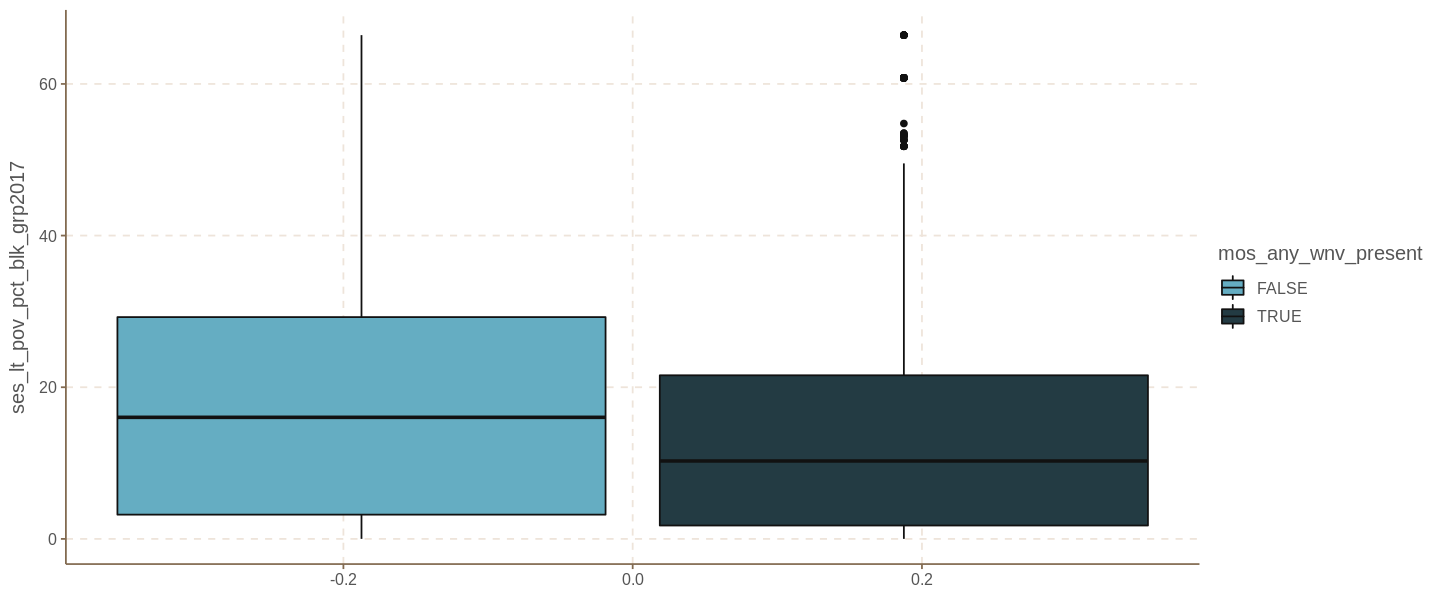

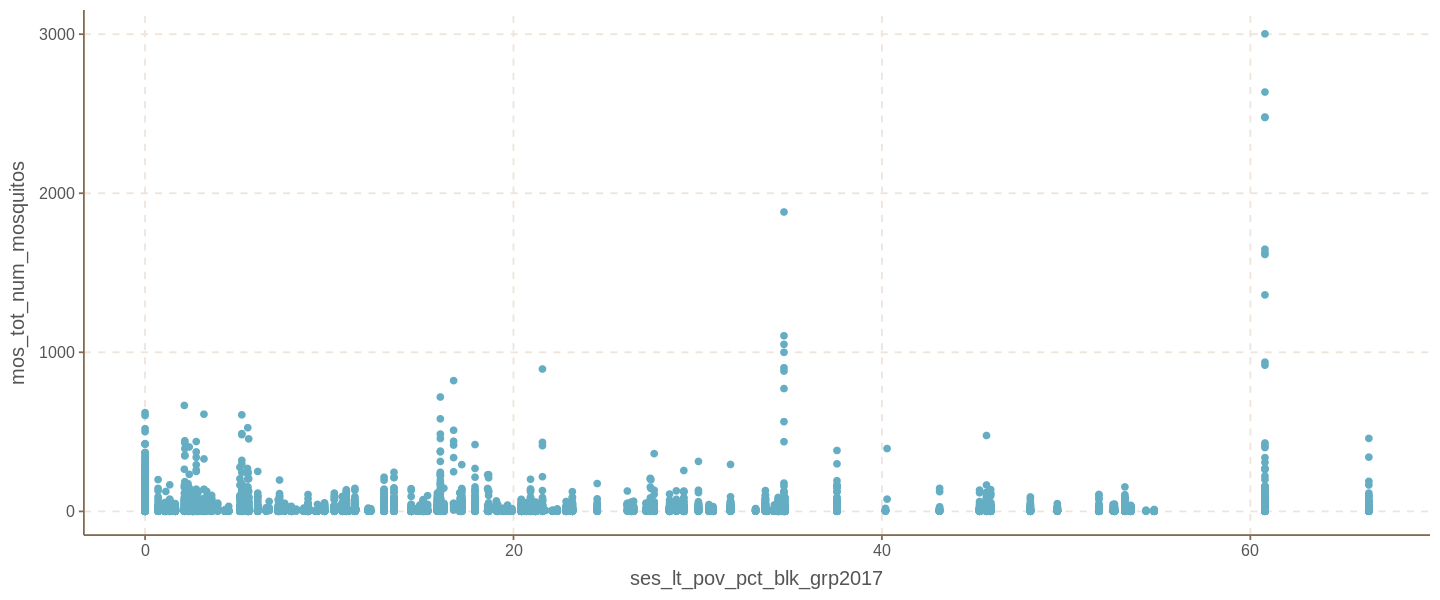

In [171]:
df_train %>%
    ggplot()+
    geom_boxplot(aes(y=ses_lt_pov_pct_blk_grp2017,fill=mos_any_wnv_present))
df_train %>%
    ggplot()+
    geom_point(aes(x=ses_lt_pov_pct_blk_grp2017,y=mos_tot_num_mosquitos))

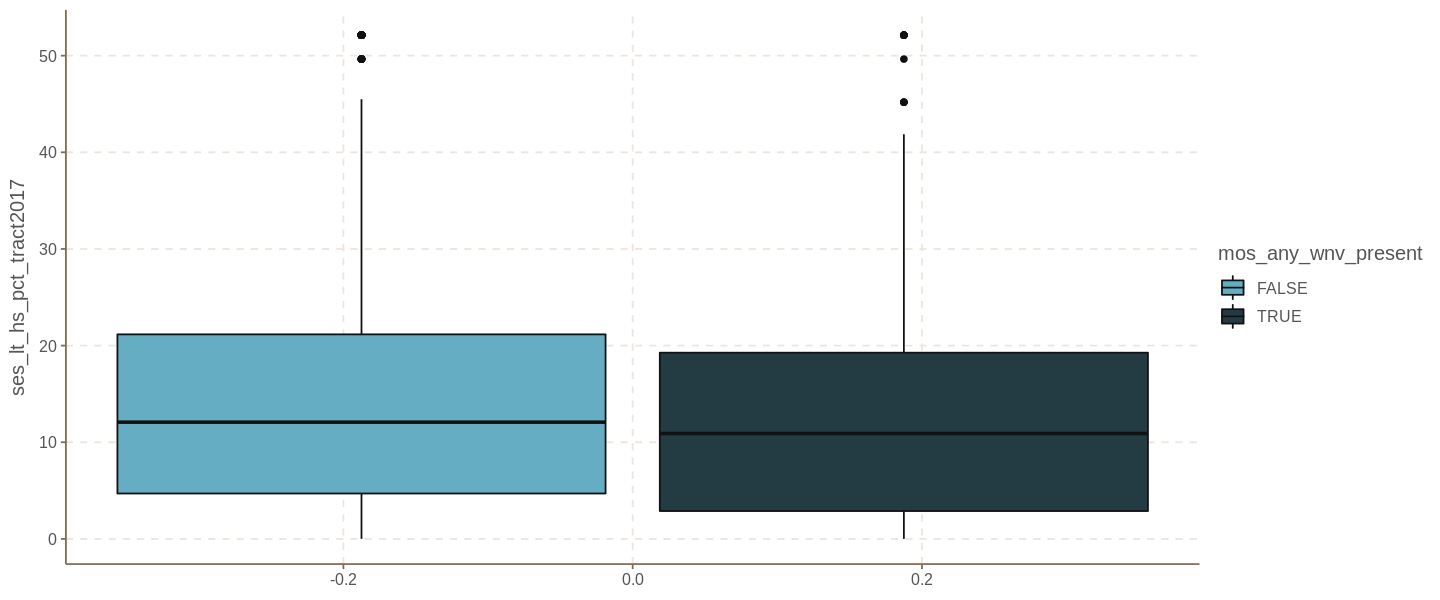

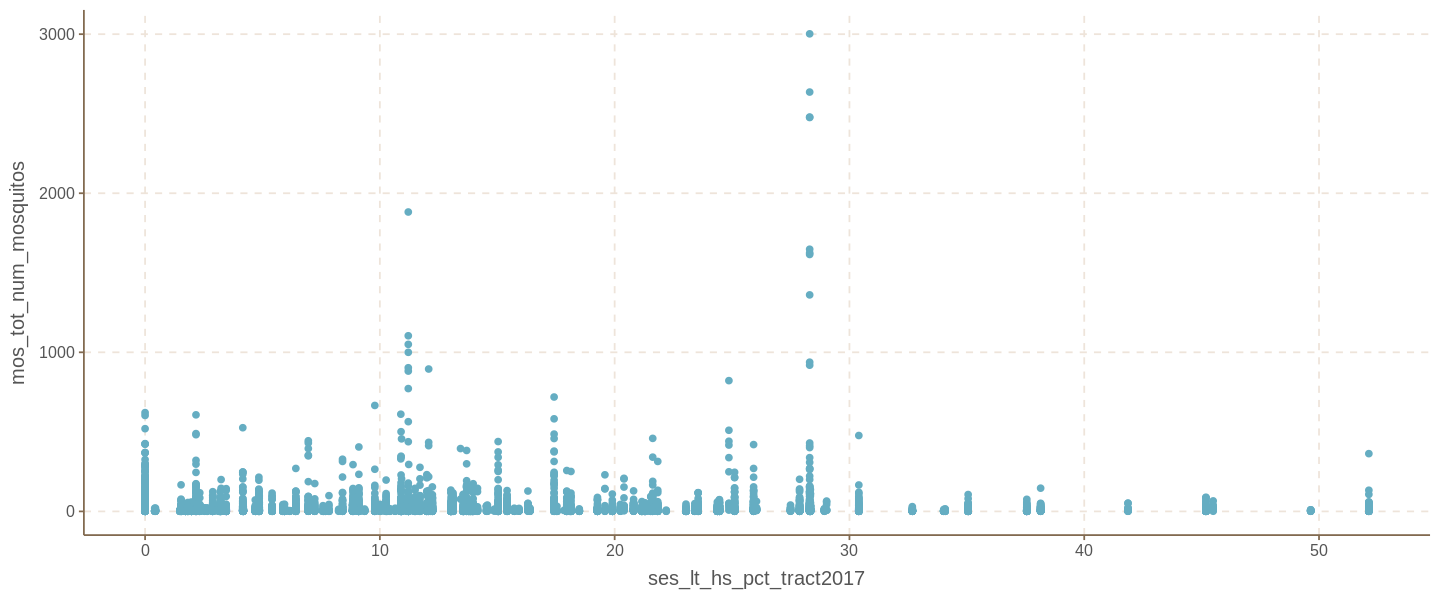

In [174]:
df_train %>%
    ggplot()+
    geom_boxplot(aes(y=ses_lt_hs_pct_tract2017,fill=mos_any_wnv_present))
df_train %>%
    ggplot()+
    geom_point(aes(x=ses_lt_hs_pct_tract2017,y=mos_tot_num_mosquitos))

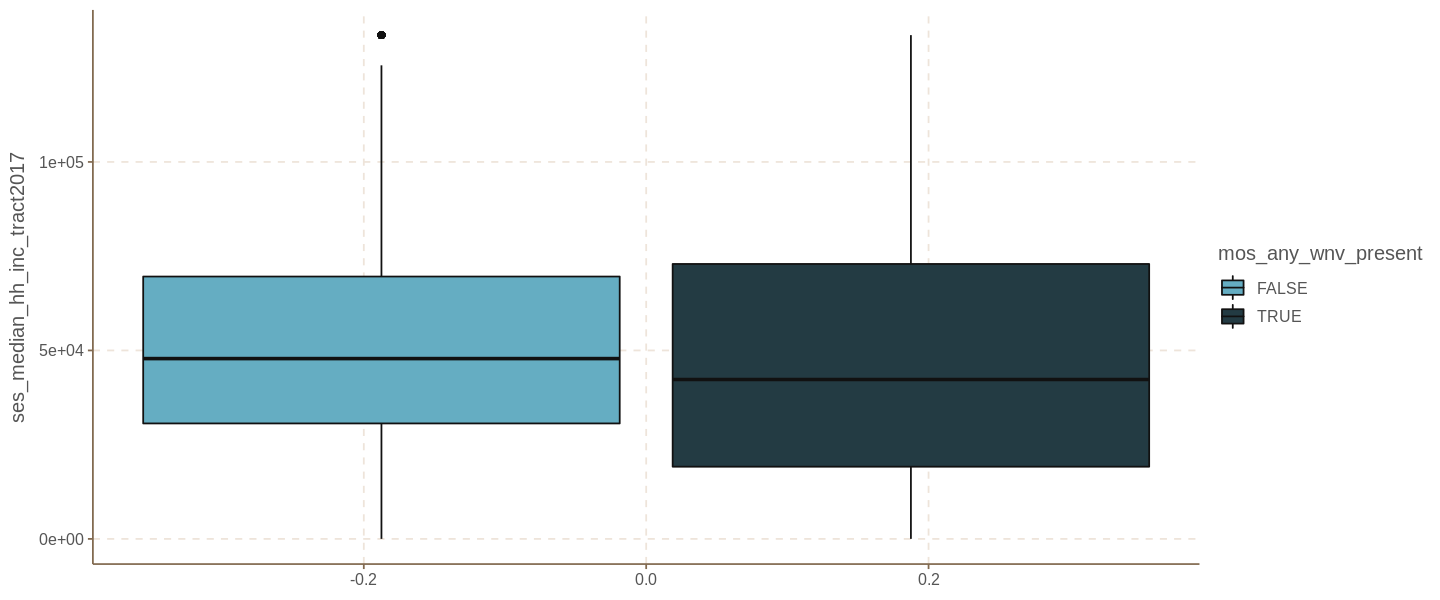

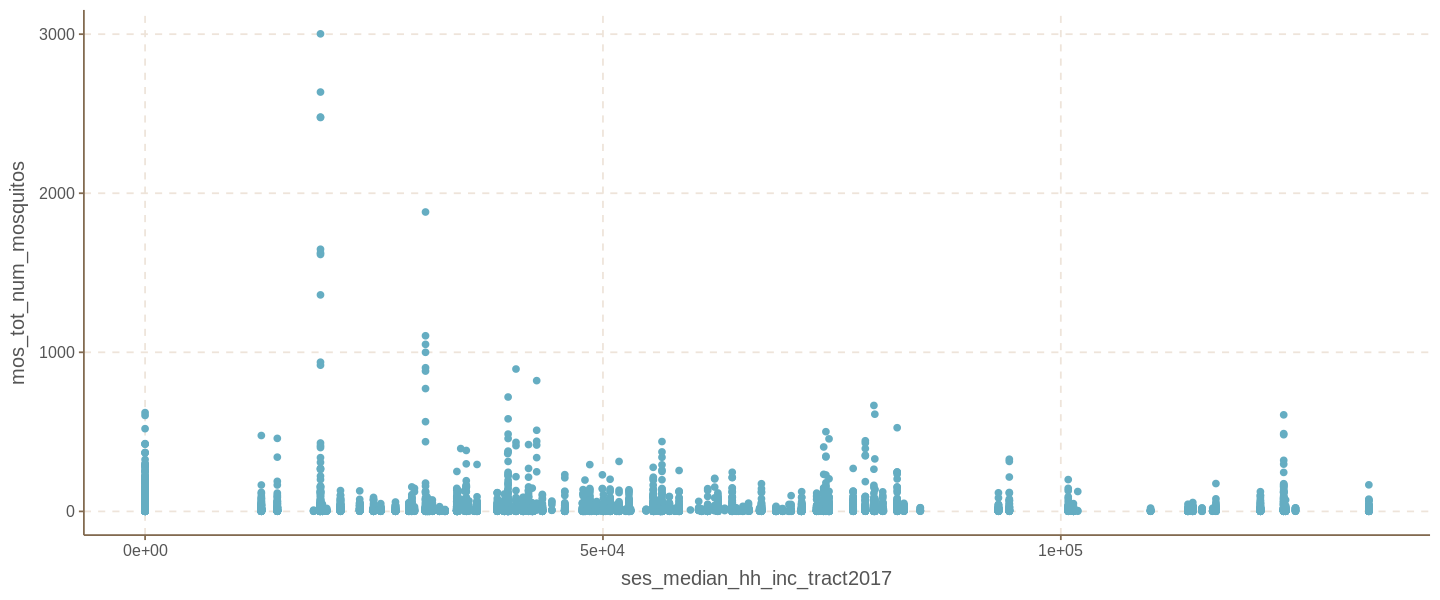

In [175]:
df_train %>%
    ggplot()+
    geom_boxplot(aes(y=ses_median_hh_inc_tract2017,fill=mos_any_wnv_present))
df_train %>%
    ggplot()+
    geom_point(aes(x=ses_median_hh_inc_tract2017,y=mos_tot_num_mosquitos))

This one seems to have the most promise -->

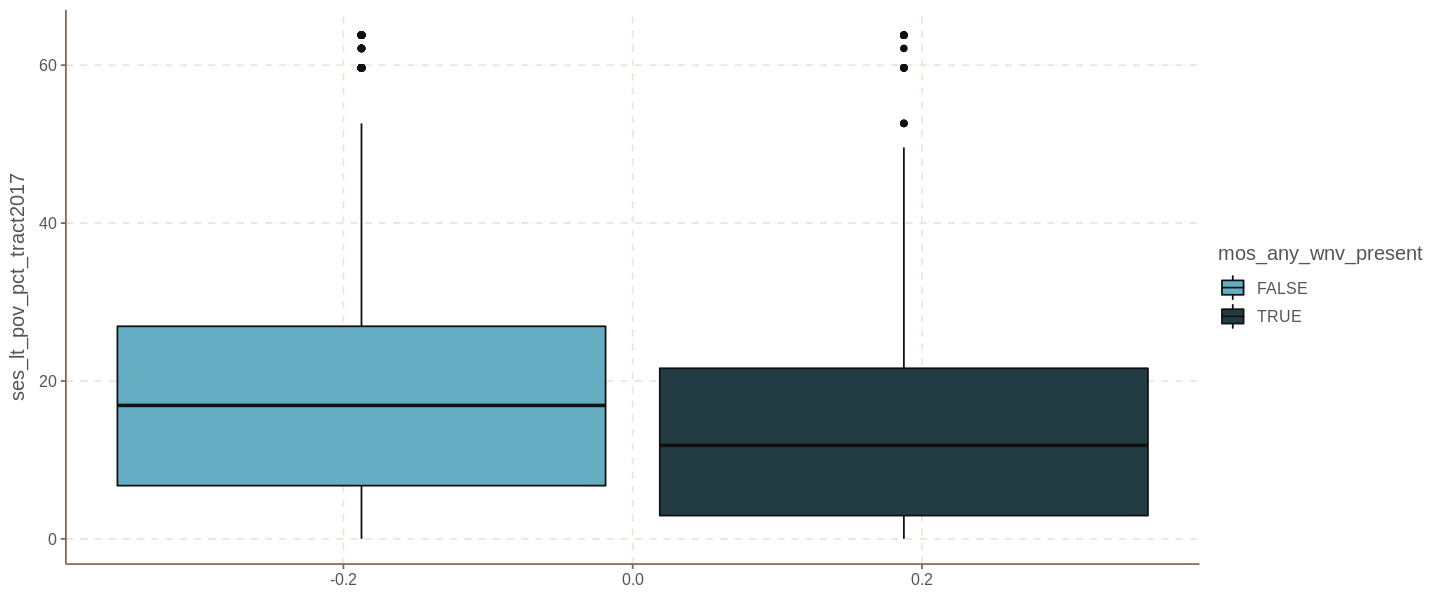

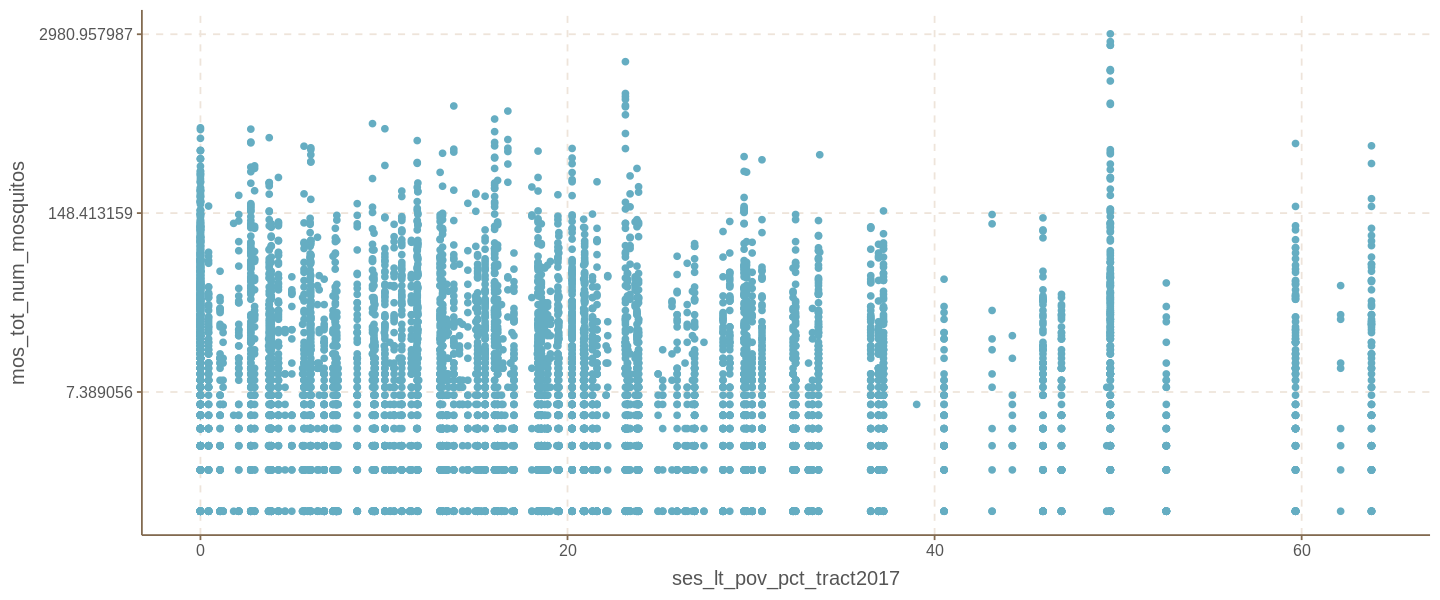

In [211]:
df_train %>%
    ggplot()+
    geom_boxplot(aes(y=ses_lt_pov_pct_tract2017,fill=mos_any_wnv_present))
df_train %>%
    ggplot()+
    geom_point(aes(x=ses_lt_pov_pct_tract2017,y=mos_tot_num_mosquitos))+
    scale_y_continuous(trans = "log")

# Do the neighbourhood variables offer any value?

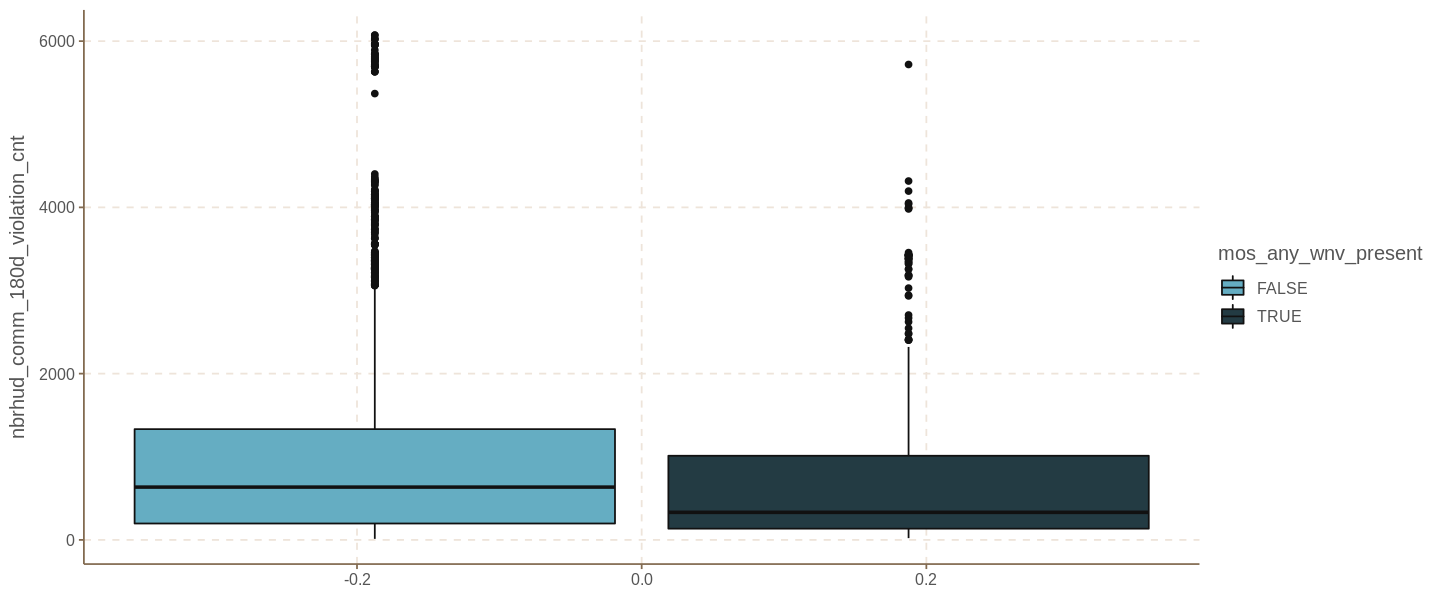

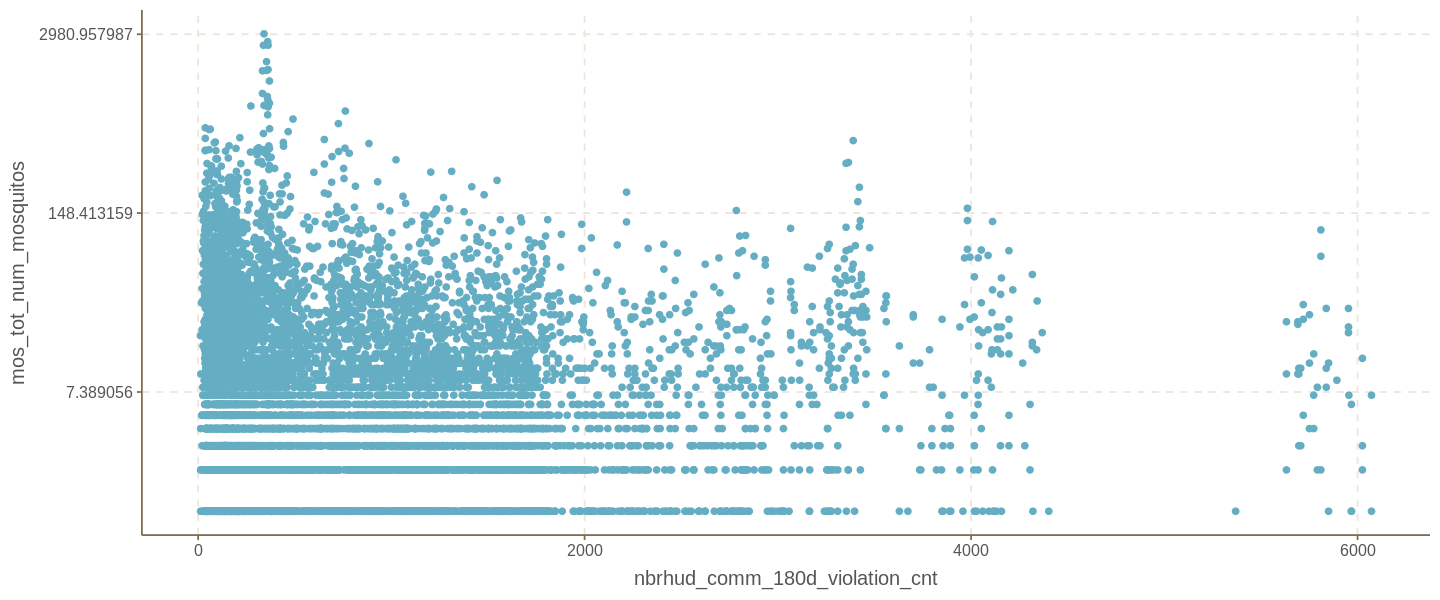

In [210]:
df_train %>%
    ggplot()+
    geom_boxplot(aes(y=nbrhud_comm_180d_violation_cnt,fill=mos_any_wnv_present))
df_train %>%
    ggplot()+
    geom_point(aes(x=nbrhud_comm_180d_violation_cnt,y=mos_tot_num_mosquitos))+
    scale_y_continuous(trans = "log")

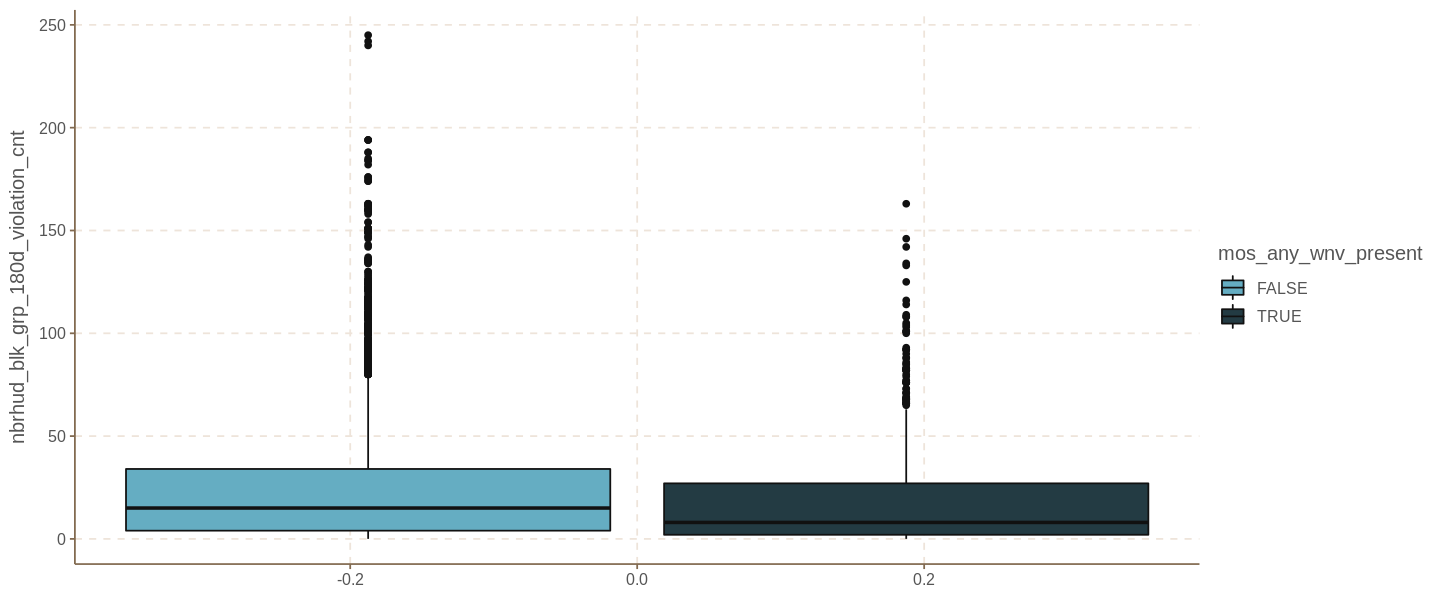

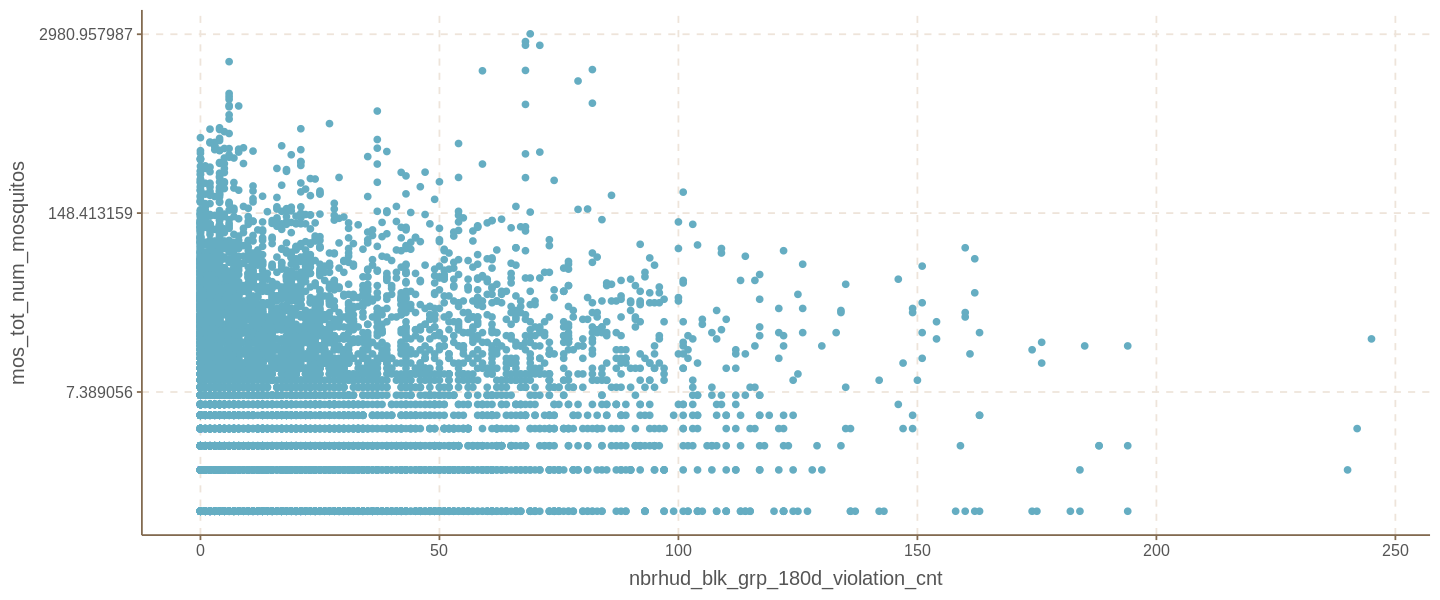

In [209]:
df_train %>%
    ggplot()+
    geom_boxplot(aes(y=nbrhud_blk_grp_180d_violation_cnt,fill=mos_any_wnv_present))
df_train %>%
    ggplot()+
    geom_point(aes(x=nbrhud_blk_grp_180d_violation_cnt,y=mos_tot_num_mosquitos))+
    scale_y_continuous(trans = "log")

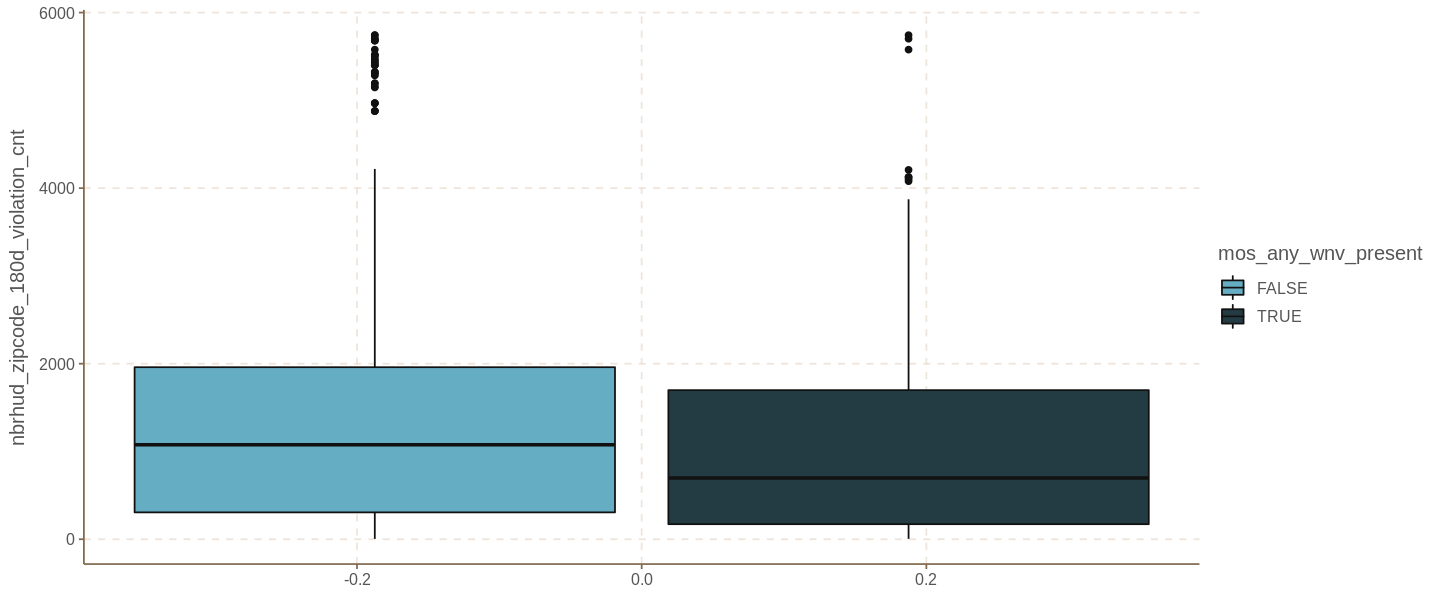

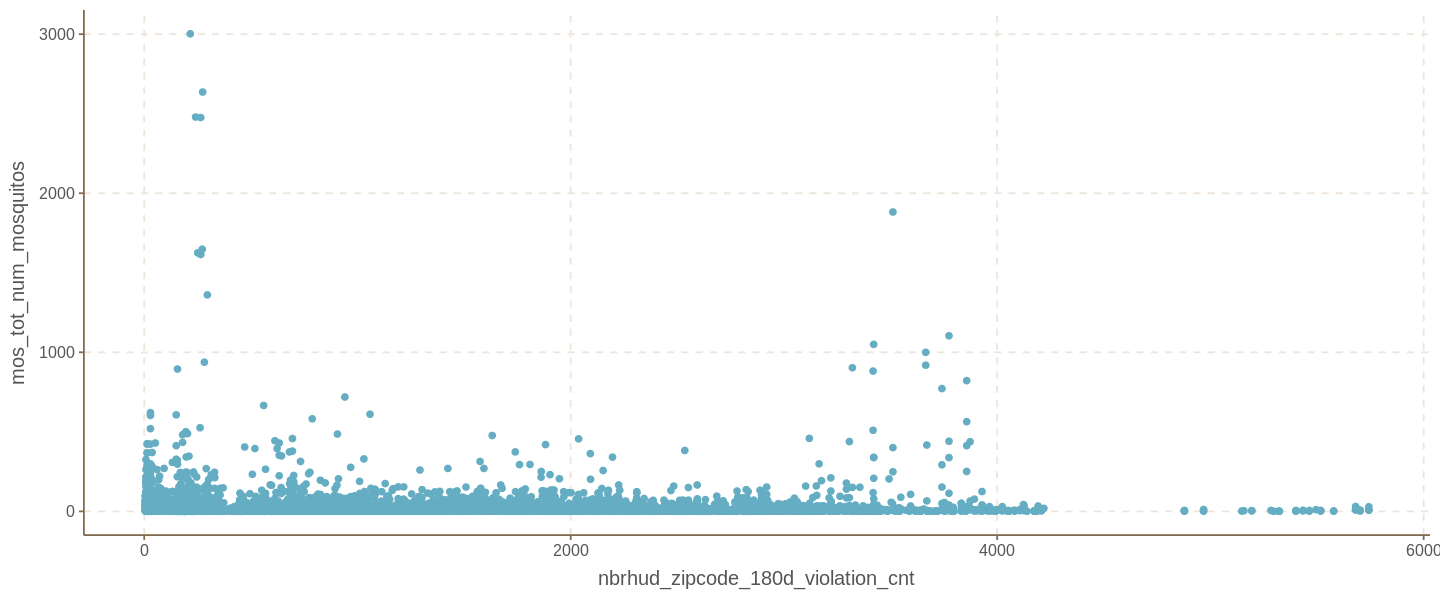

In [201]:
df_train %>%
    ggplot()+
    geom_boxplot(aes(y=nbrhud_zipcode_180d_violation_cnt,fill=mos_any_wnv_present))
df_train %>%
    ggplot()+
    geom_point(aes(x=nbrhud_zipcode_180d_violation_cnt,y=mos_tot_num_mosquitos))

Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Removed 6564 rows containing non-finite values (stat_boxplot).”

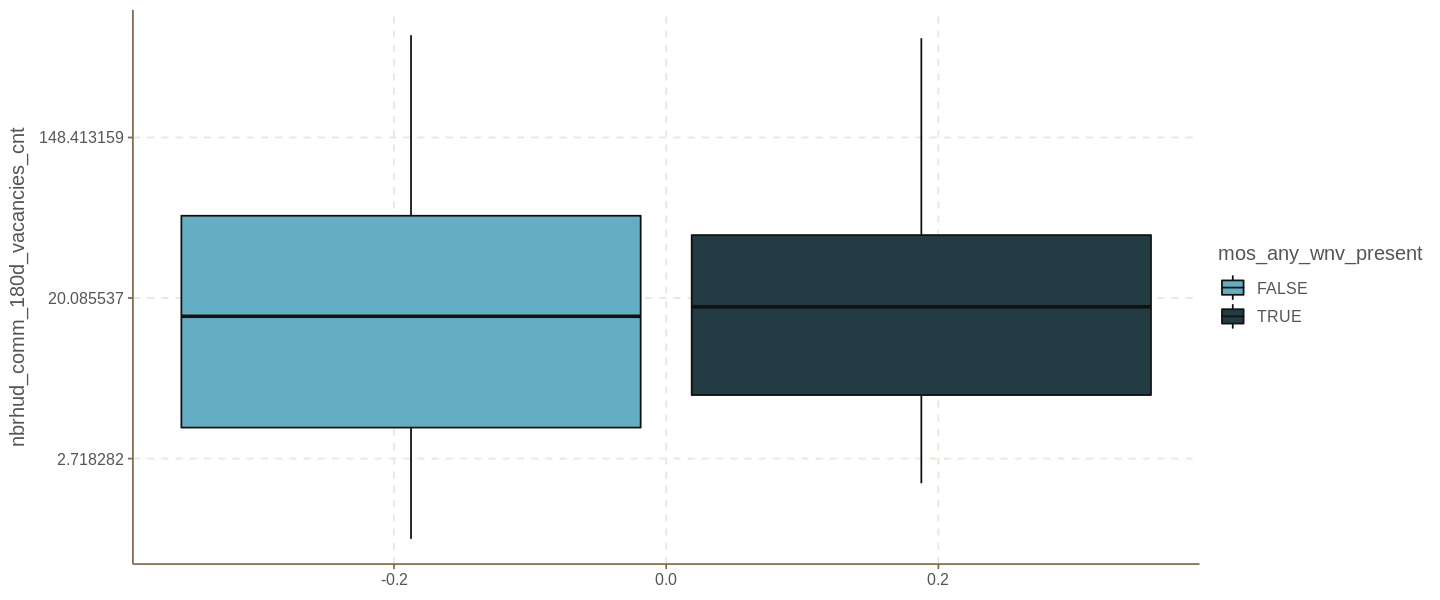

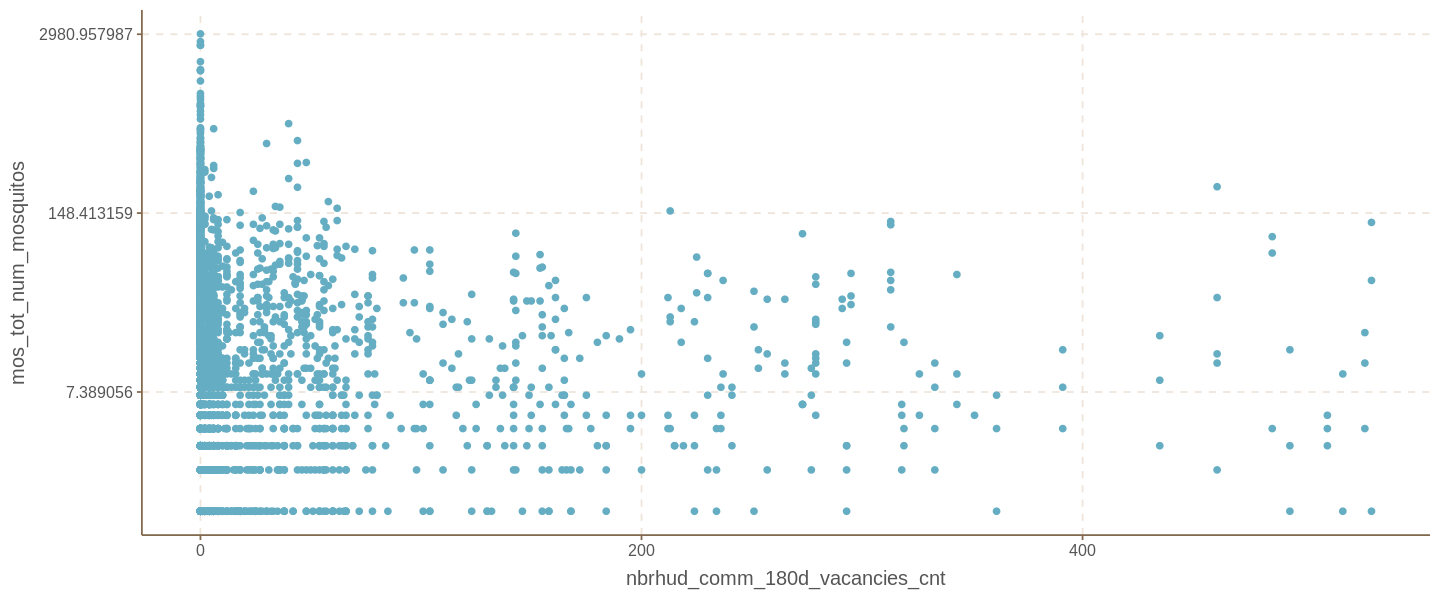

In [206]:
df_train %>%
    ggplot()+
    geom_boxplot(aes(y=nbrhud_comm_180d_vacancies_cnt,fill=mos_any_wnv_present))+
    scale_y_continuous(trans = "log")
df_train %>%
    ggplot()+
    geom_point(aes(x=nbrhud_comm_180d_vacancies_cnt,y=mos_tot_num_mosquitos))+
    scale_y_continuous(trans = "log")

Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Removed 7960 rows containing non-finite values (stat_boxplot).”

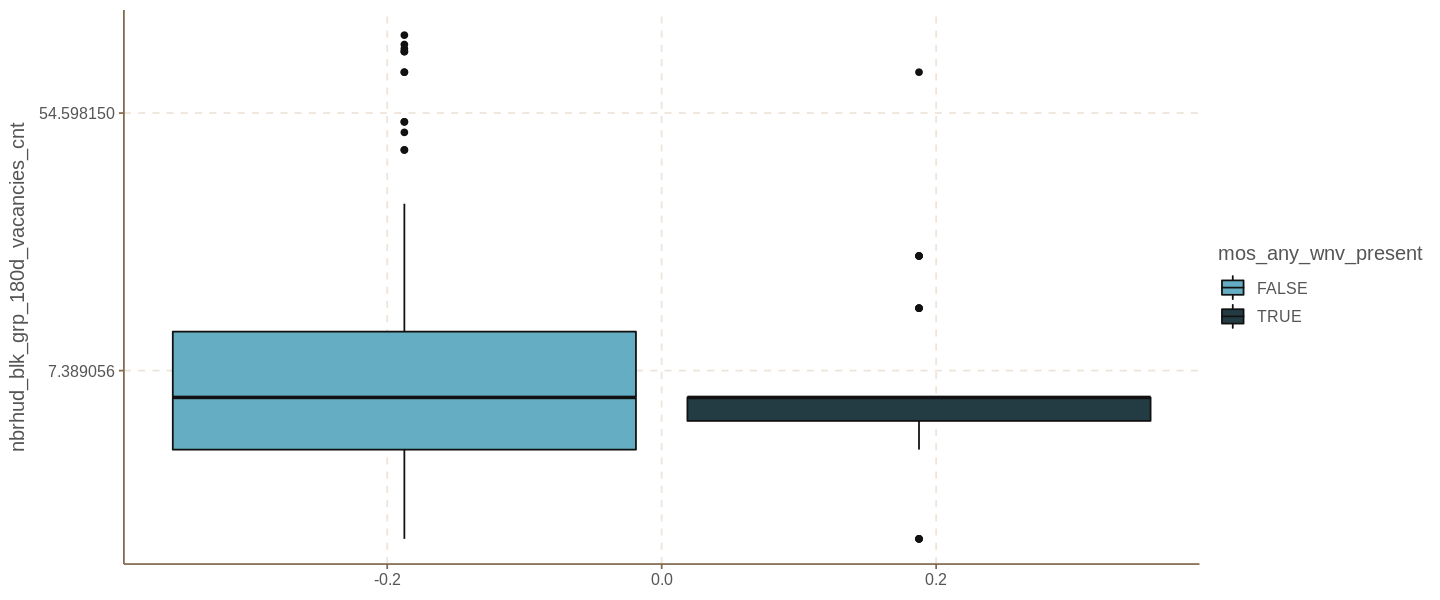

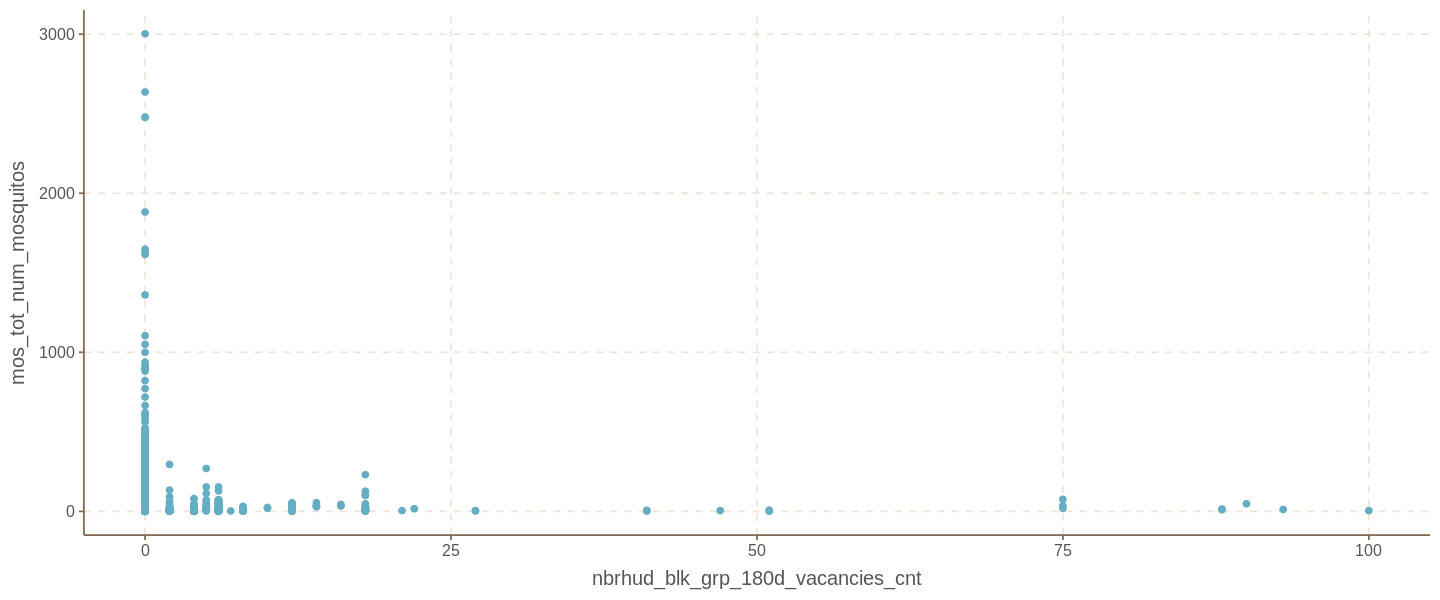

In [207]:
df_train %>%
    ggplot()+
    geom_boxplot(aes(y=nbrhud_blk_grp_180d_vacancies_cnt,fill=mos_any_wnv_present))+
    scale_y_continuous(trans = "log")
df_train %>%
    ggplot()+
    geom_point(aes(x=nbrhud_blk_grp_180d_vacancies_cnt,y=mos_tot_num_mosquitos))

Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Removed 6271 rows containing non-finite values (stat_boxplot).”

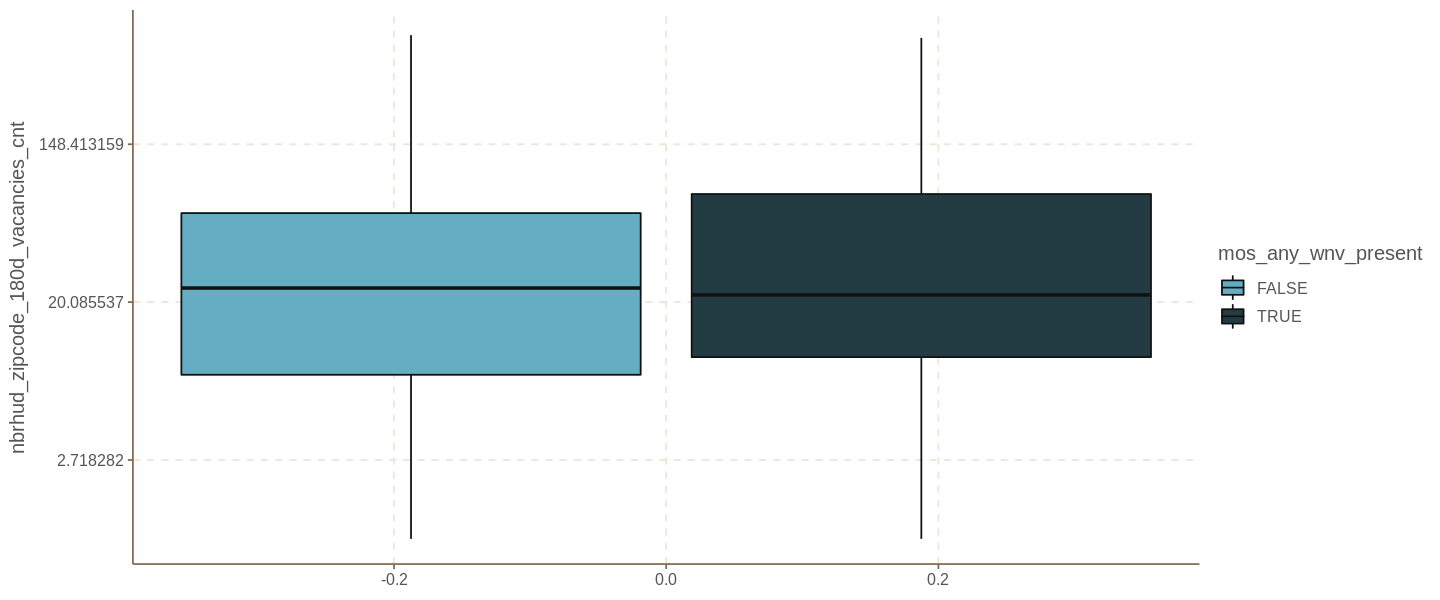

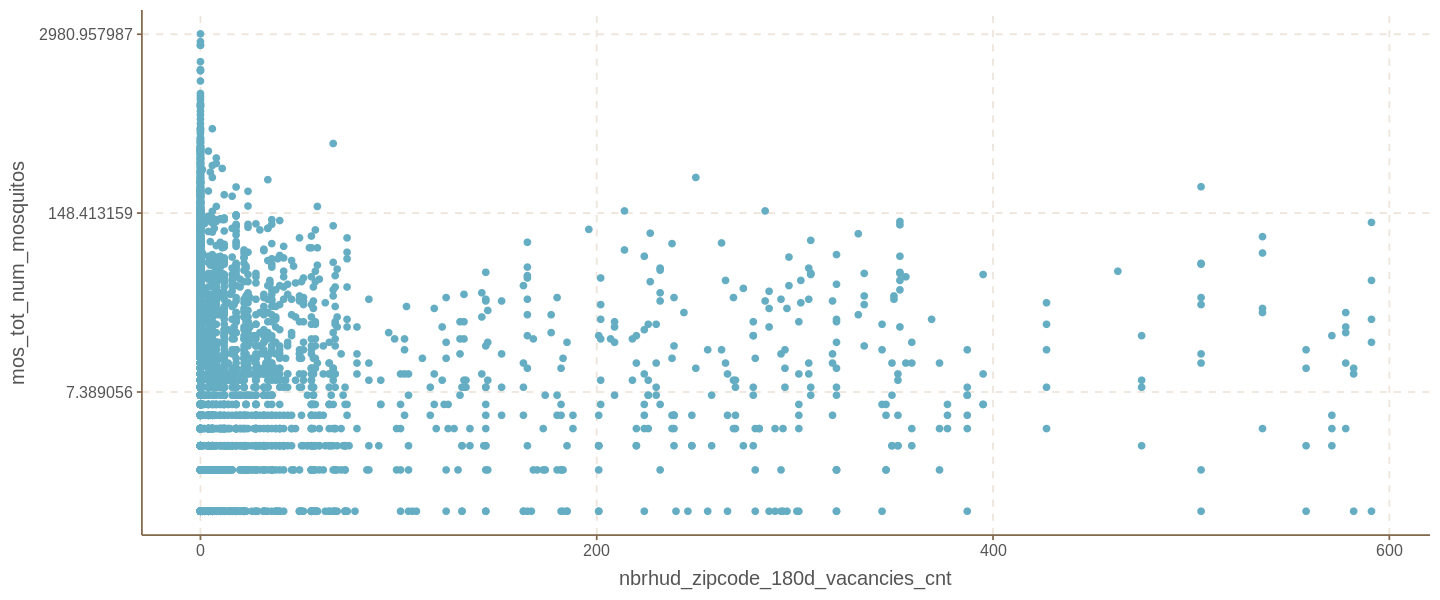

In [212]:
df_train %>%
    ggplot()+
    geom_boxplot(aes(y=nbrhud_zipcode_180d_vacancies_cnt,fill=mos_any_wnv_present))+
    scale_y_continuous(trans = "log")
df_train %>%
    ggplot()+
    geom_point(aes(x=nbrhud_zipcode_180d_vacancies_cnt,y=mos_tot_num_mosquitos))+
    scale_y_continuous(trans = "log")

# Now looking at the weather

## OHare Weather

In [181]:
df_sub = df_train %>% dplyr::select("t_date",starts_with("wea_ohare_"),"mos_any_wnv_present","mos_tot_num_mosquitos")

In [182]:
head(df_sub)

t_date     wea_ohare_prcp wea_ohare_tavg2 wea_ohare_tmax wea_ohare_tmin
1 2007-05-29 0              74              88             60            
2 2007-05-29 0              74              88             60            
3 2007-05-29 0              74              88             60            
4 2007-05-29 0              74              88             60            
5 2007-05-29 0              74              88             60            
6 2007-05-29 0              74              88             60            
  wea_ohare_tavg2_ma7 wea_ohare_tavg2_ma60 wea_ohare_prcp_sum7
1 67.35714            54.375               1.07               
2 67.35714            54.375               1.07               
3 67.35714            54.375               1.07               
4 67.35714            54.375               1.07               
5 67.35714            54.375               1.07               
6 67.35714            54.375               1.07               
  wea_ohare_prcp_sum60 wea_ohare_prcp_sum60_lag7 ⋯ wea_ohare_tavg2_ma60_lag28
1 5.79                 4.96                      ⋯ 44.69167                  
2 5.79                 4.96                      ⋯ 44.69167                  
3 5.79                 4.96                      ⋯ 44.69167                  
4 5.79                 4.96                      ⋯ 44.69167                  
5 5.79                 4.96                      ⋯ 44.69167                  
6 5.79                 4.96                      ⋯ 44.69167                  
  wea_ohare_tavg2_ma60_lag35 wea_ohare_tavg2_ma60_lag42
1 42.1                       38.61667                  
2 42.1                       38.61667                  
3 42.1                       38.61667                  
4 42.1                       38.61667                  
5 42.1                       38.61667                  
6 42.1                       38.61667                  
  wea_ohare_tavg2_ma60_lag49 wea_ohare_tavg2_ma60_lag56
1 35.55                      31.775                    
2 35.55                      31.775                    
3 35.55                      31.775                    
4 35.55                      31.775                    
5 35.55                      31.775                    
6 35.55                      31.775                    
  wea_ohare_tavg2_ma60_lag63 wea_ohare_tavg2_ma60_lag90
1 27.80833                   23.83333                  
2 27.80833                   23.83333                  
3 27.80833                   23.83333                  
4 27.80833                   23.83333                  
5 27.80833                   23.83333                  
6 27.80833                   23.83333                  
  wea_ohare_tavg2_ma60_lag120 mos_any_wnv_present mos_tot_num_mosquitos
1 31.73333                    FALSE               2                    
2 31.73333                    FALSE               1                    
3 31.73333                    FALSE               5                    
4 31.73333                    FALSE               2                    
5 31.73333                    FALSE               1                    
6 31.73333                    FALSE               3

The various lag variables created so far are HIGHLY correlated. We'll need to be selective during modeling.

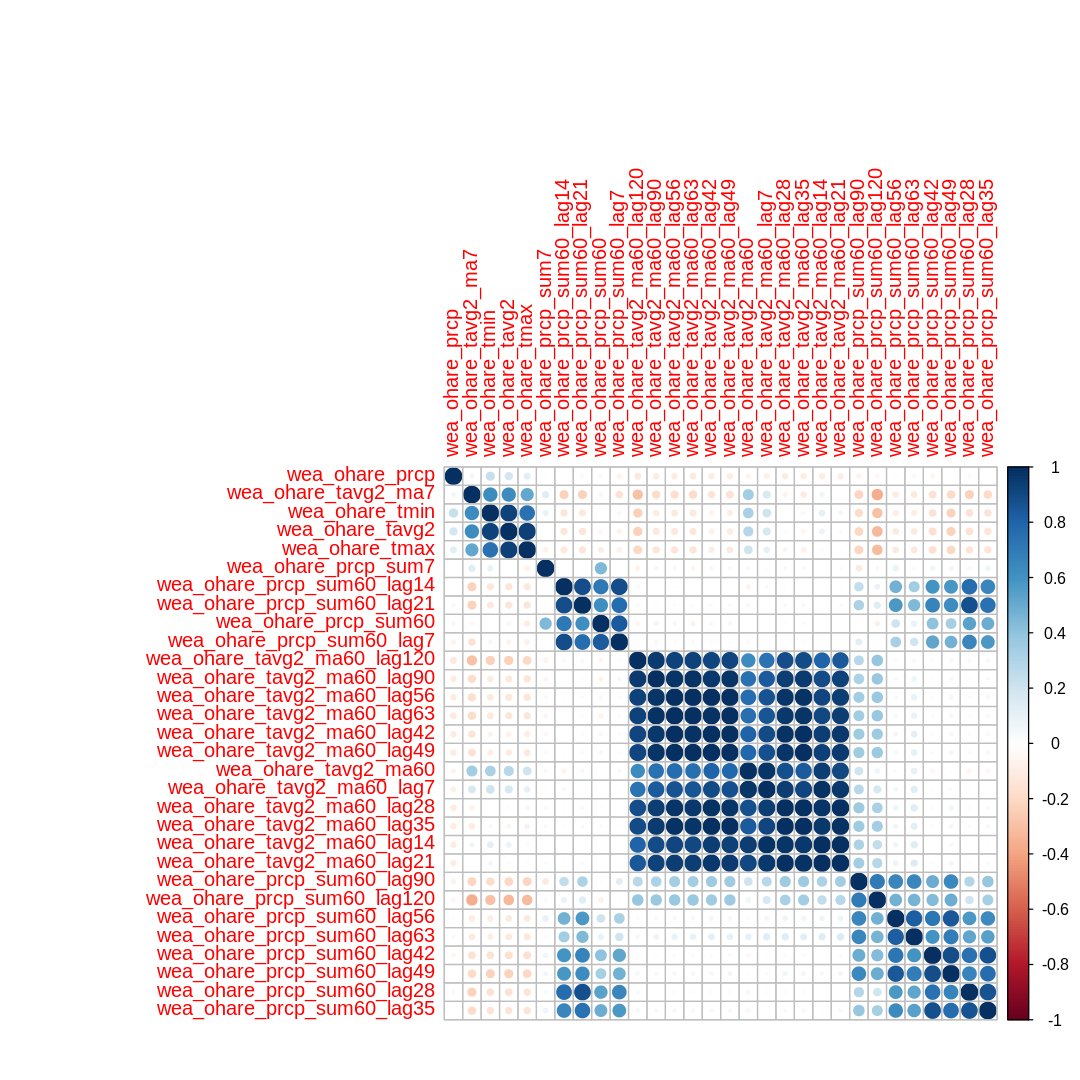

In [189]:
options(repr.plot.width=9, repr.plot.height=9)
cor(df_sub %>% select(starts_with("wea"))) %>% corrplot::corrplot(order = "hclust")

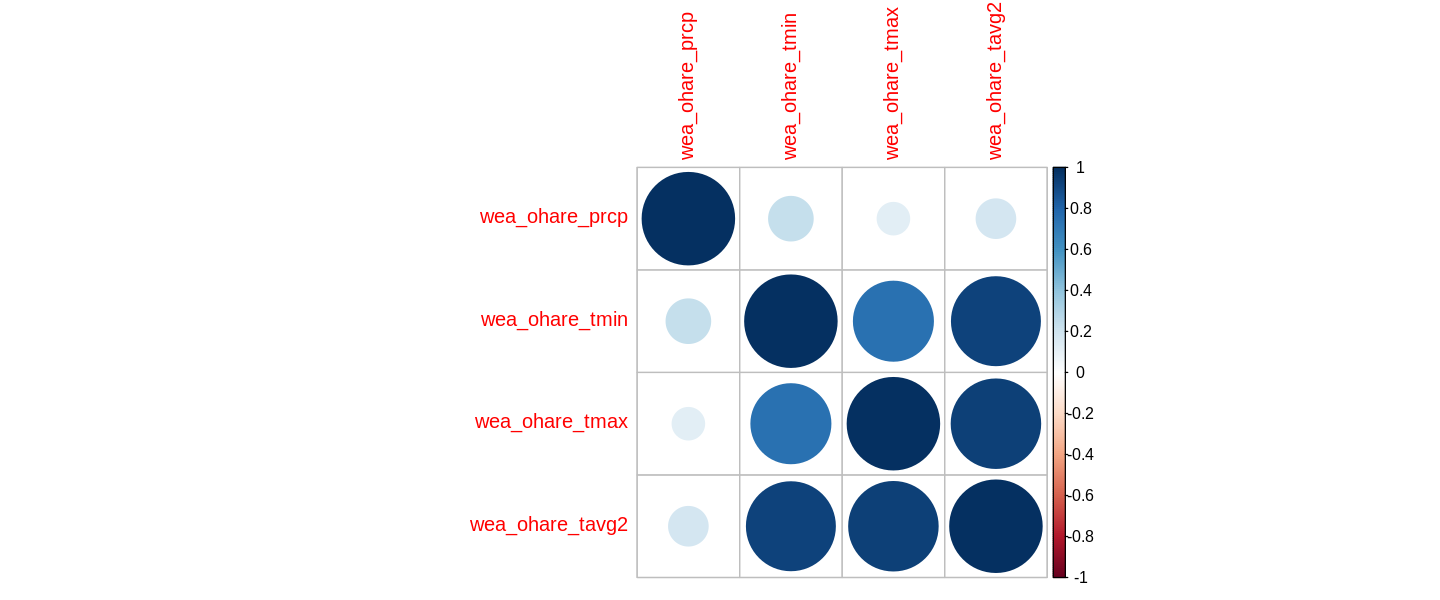

In [198]:
options(repr.plot.width=12, repr.plot.height=5)
df_sub %>% 
    select(ends_with("prcp"),ends_with("tmin"),ends_with("tmax"),ends_with("tavg2")) %>% 
    cor() %>% 
    corrplot::corrplot(order = "hclust")

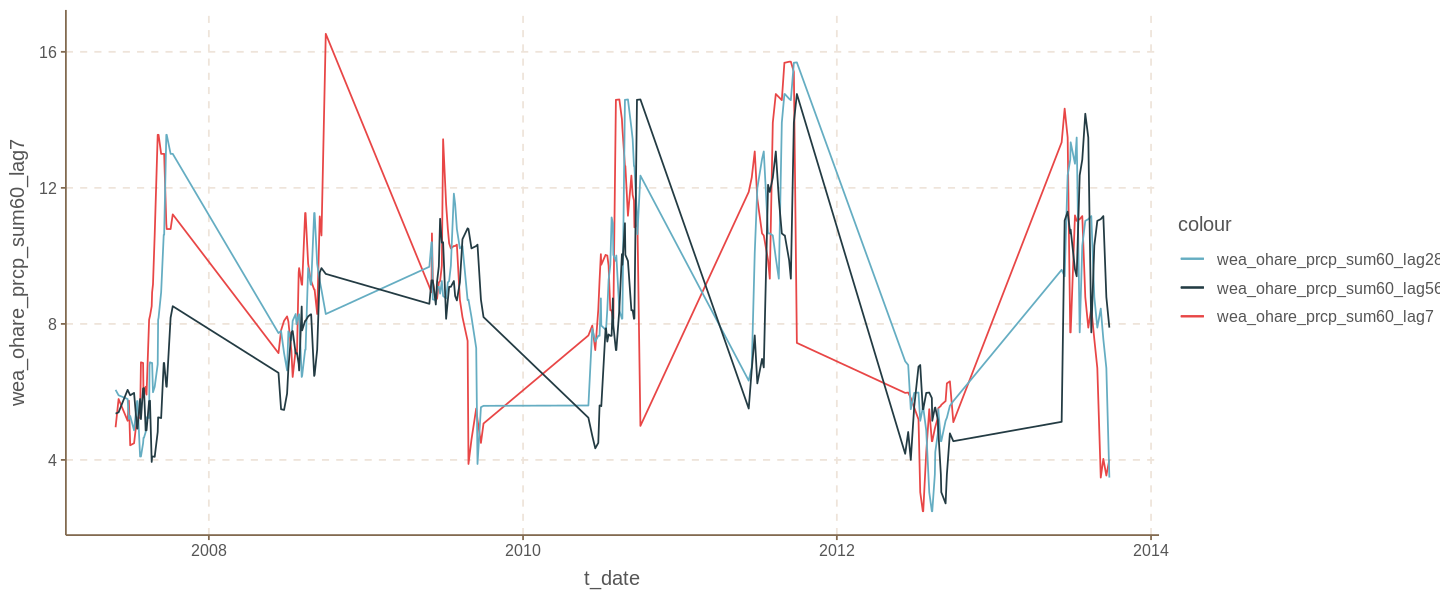

In [217]:
df_sub %>%
    ggplot(aes(x=t_date))+
    geom_line(aes(y=wea_ohare_prcp_sum60_lag7,color="wea_ohare_prcp_sum60_lag7"))+
    geom_line(aes(y=wea_ohare_prcp_sum60_lag28,color="wea_ohare_prcp_sum60_lag28"))+
    geom_line(aes(y=wea_ohare_prcp_sum60_lag56,color="wea_ohare_prcp_sum60_lag56"))